# 0.0 Imports

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
    
from scipy                   import stats
from tabulate                import tabulate
from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine
from boruta                  import BorutaPy
from imblearn                import under_sampling as us
from imblearn                import over_sampling as os
from sklearn.preprocessing   import RobustScaler, MinMaxScaler
from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
from lightgbm                import LGBMClassifier
from sklearn.metrics         import make_scorer,accuracy_score, classification_report,recall_score,f1_score,roc_auc_score, plot_precision_recall_curve, precision_score,roc_curve
from scikitplot              import metrics      as mt
from sklearn.model_selection import cross_validate, train_test_split
from sklearn                 import svm
from sklearn.ensemble        import RandomForestClassifier,ExtraTreesClassifier,IsolationForest
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2cor = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcor = k - (k-1)**2/(n-1)
    rcor = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2cor/n) / (min(kcor-1,rcor-1)))

def results_cv(result):
    dataframe = pd.DataFrame()
    for i in result:
        dataframe[i] = [np.round( np.nanmean( result[i]), 6 ).astype( str ) + ' +/- ' + np.round( np.nanstd( result[i]), 8 ).astype( str )]
    dataframe.columns=['a','a','Accuracy CV', 'Precision_score CV', 'Recall CV', 'F1-Score CV'] 
    dataframe = dataframe[['Accuracy CV', 'F1-Score CV','Recall CV', 'Precision_score CV']]
    return dataframe

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('data/data.csv', low_memory=False)

In [22]:
df_rawm, df_final_test = train_test_split(df_raw, train_size = 0.7, random_state = 42,stratify =df_raw['isFraud'])

In [23]:
df_final_test.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1453282,140,PAYMENT,6974.39,C2082621352,10503.00,3528.61,M1499555496,0.00,0.00,0,0
5338477,374,CASH_IN,157690.96,C452124917,16627.00,174317.96,C1856284436,73436.77,0.00,0,0
2396500,201,PAYMENT,17907.49,C1149130676,16282.06,0.00,M811584793,0.00,0.00,0,0
4577381,328,PAYMENT,22394.94,C1869542815,75530.38,53135.44,M1527681304,0.00,0.00,0,0
2922798,229,CASH_OUT,106631.35,C544369672,0.00,0.00,C285714859,2210314.37,2316945.72,0,0


In [5]:
print('Number of Rows: {}'. format(df_rawm.shape[0]))
print('Number of Columns: {}'. format(df_rawm.shape[1]))

Number of Rows: 4453834
Number of Columns: 11


In [6]:
print('Number of Rows: {}'. format(df_final_test.shape[0]))
print('Number of Columns: {}'. format(df_final_test.shape[1]))

Number of Rows: 1908786
Number of Columns: 11


In [7]:
df_rawm.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4310249,308,CASH_IN,260485.23,C386091144,32371.00,292856.23,C268784004,4633560.35,4373075.12,0,0
318938,16,TRANSFER,1387060.19,C977405179,432673.78,0.00,C1032483118,0.00,1033440.62,0,0
3375139,254,TRANSFER,1140661.98,C1091684896,59947.00,0.00,C1969901822,15000.85,1155662.83,0,0
5492781,380,CASH_IN,169390.39,C300199504,80047.10,249437.49,C591887141,1467039.66,1297649.27,0,0
807263,40,CASH_IN,4867.26,C905217988,5989226.14,5994093.40,C926869366,1609385.28,1604518.02,0,0
2224826,186,CASH_OUT,149232.25,C1341533880,48976.00,0.00,C195684796,74673.95,223906.21,0,0
2969206,231,CASH_OUT,110195.91,C1266699174,0.00,0.00,C1777623152,194576.29,304772.19,0,0
2389649,201,CASH_OUT,52697.72,C891545569,0.00,0.00,C1056797562,1490655.11,1543352.83,0,0
3477291,258,CASH_IN,80358.70,C189878749,102034.72,182393.42,C828228192,498718.30,418359.60,0,0
5232366,371,CASH_OUT,213680.23,C1498633862,8436.00,0.00,C1576836568,596399.98,810080.22,0,0


# 1.0 Data description

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [8]:
df1 = df_rawm.copy()

In [9]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

## 1.1  Rename Columns

In [10]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

cols_new = ['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud']

# rename
df1.columns = cols_new

df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.2  Data Dimensions

In [11]:
print('Number of Rows: {}'. format(df1.shape[0]))
print('Number of Columns: {}'. format(df1.shape[1]))

Number of Rows: 4453834
Number of Columns: 11


## 1.3 Data types

In [12]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Check NA

In [13]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5 Change Types

In [16]:
df1[['is_fraud','is_flagged_fraud']] = df1[['is_fraud','is_flagged_fraud']].astype(object)
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud             object
is_flagged_fraud     object
dtype: object

## 1.6 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64'])

### 1.6.1 Numerical Attributes

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.433875e+02,239.000,1.423211e+02,0.375688,0.330202
1,amount,0.0,9.244552e+07,9.244552e+07,1.799397e+05,74822.810,6.019619e+05,30.328602,1723.283104
2,oldbalance_org,0.0,5.958504e+07,5.958504e+07,8.347573e+05,14235.000,2.890121e+06,5.246103,32.936283
3,newbalance_orig,0.0,4.958504e+07,4.958504e+07,8.559756e+05,0.000,2.925904e+06,5.173527,32.024931
4,oldbalance_dest,0.0,3.560159e+08,3.560159e+08,1.100704e+06,132887.905,3.388743e+06,19.454253,898.326761
5,newbalance_dest,0.0,3.561793e+08,3.561793e+08,1.225085e+06,214938.290,3.663795e+06,18.944886,822.224926


- The median of the attributes "oldbalance_org", "newbalance_org", "oldbalance_dest", "newbalance_dest" and "amount" has a very different value in relation to the range, which indicates a large number of outliers (which can also be seen in boxplots).

In [18]:
variables = num_attributes.columns.tolist()

aux = num_attributes.copy()
aux['is_fraud'] = df1['is_fraud']

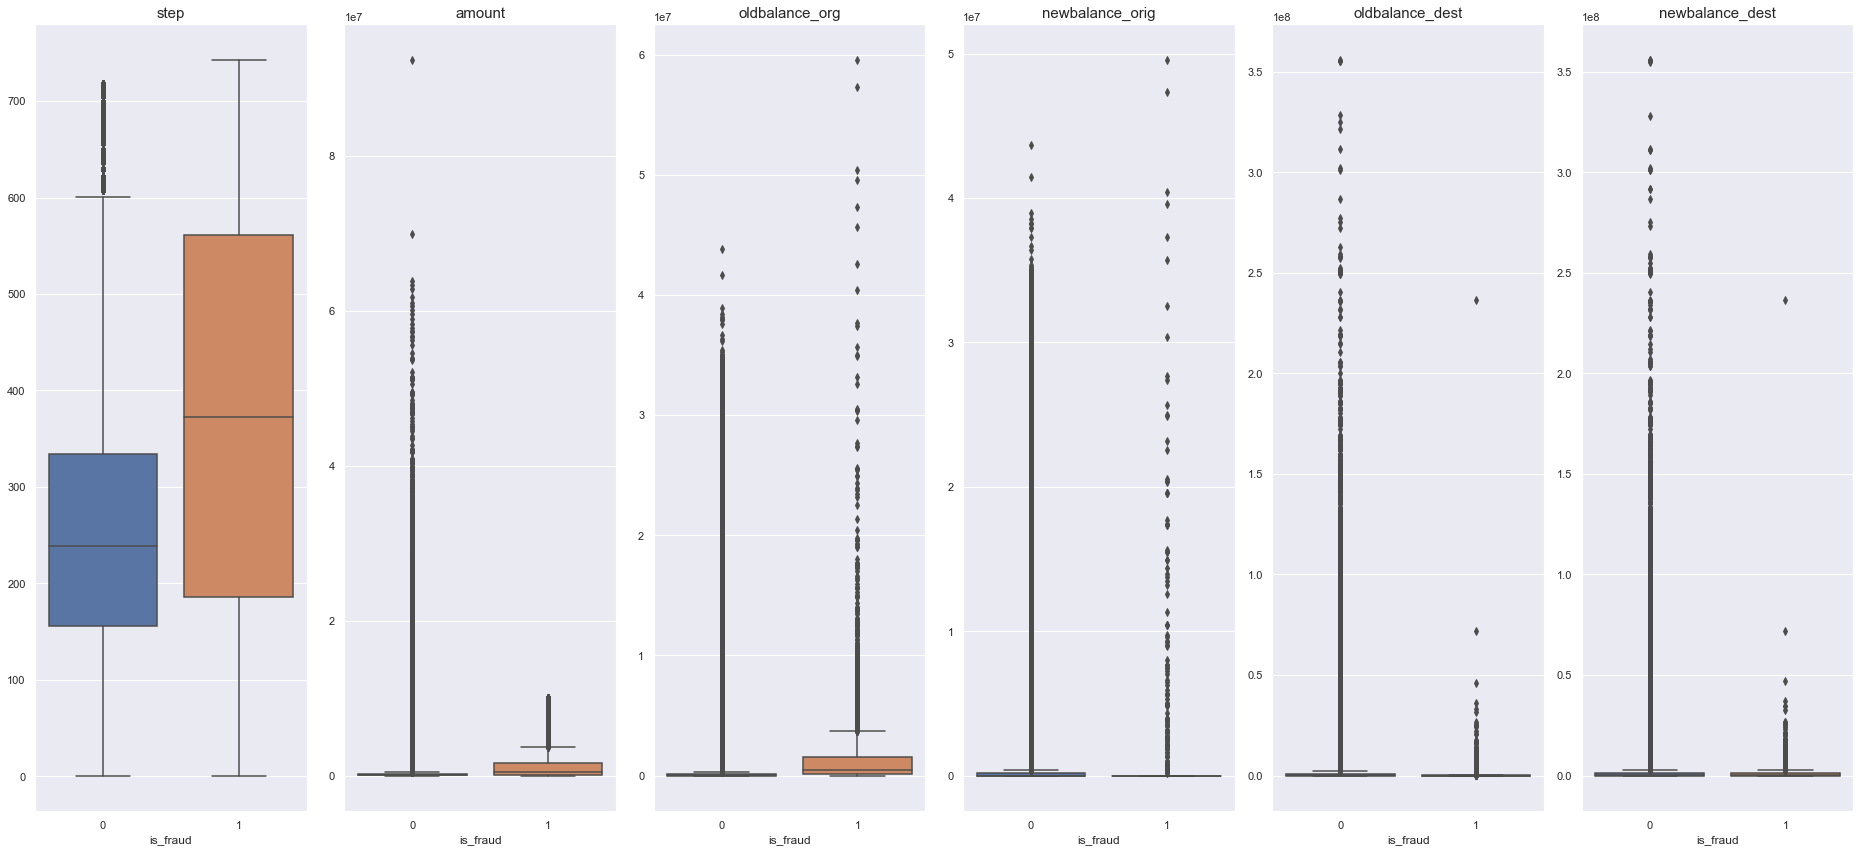

In [19]:


f, axes = plt.subplots(1, 6, figsize = (26, 12))
for var, ax in zip(variables, f.axes):

    b = sns.boxplot(y = var,x='is_fraud', data = aux, ax = ax)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")

plt.tight_layout()
plt.show()

Zoom:

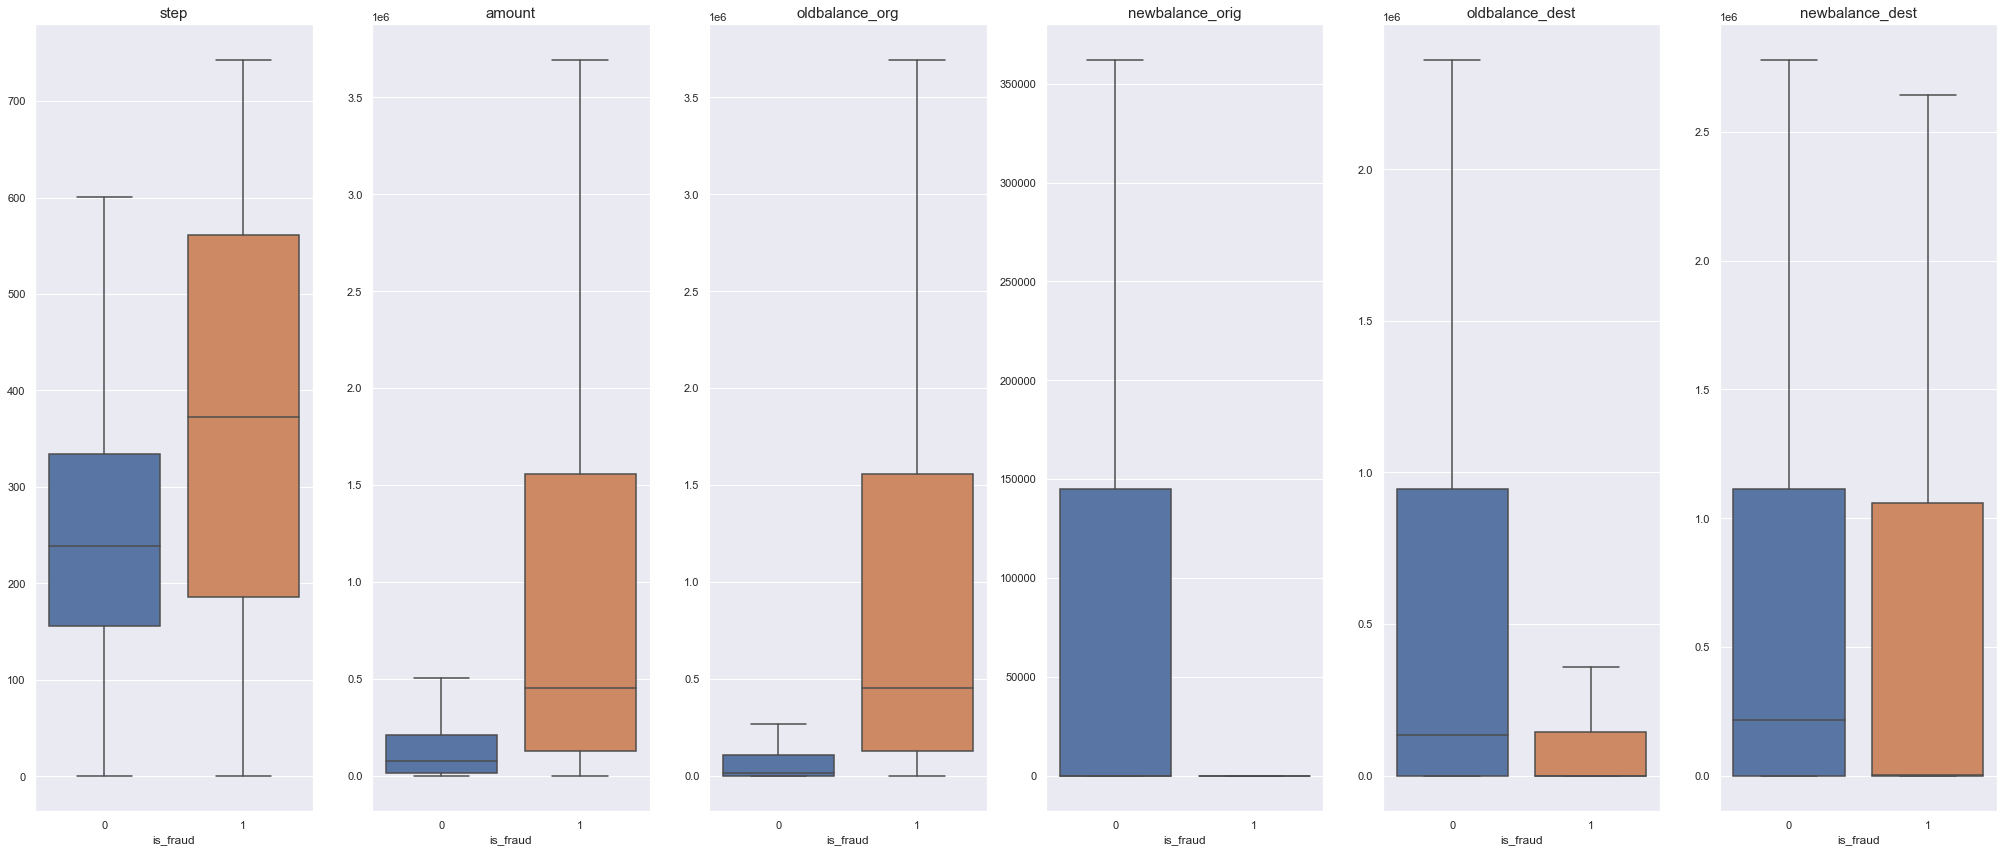

In [20]:
f, axes = plt.subplots(1, 6, figsize = (28, 12))
for var, ax in zip(variables, f.axes):
    

    b = sns.boxplot(y = var,x='is_fraud', data = aux, ax = ax,showfliers = False)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")

plt.tight_layout()
plt.show()

### 1.6.2 Categorical Attributes 

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type                      5
name_orig           4449295
name_dest           2034519
is_fraud                  2
is_flagged_fraud          2
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_flagged_fraud', ylabel='count'>

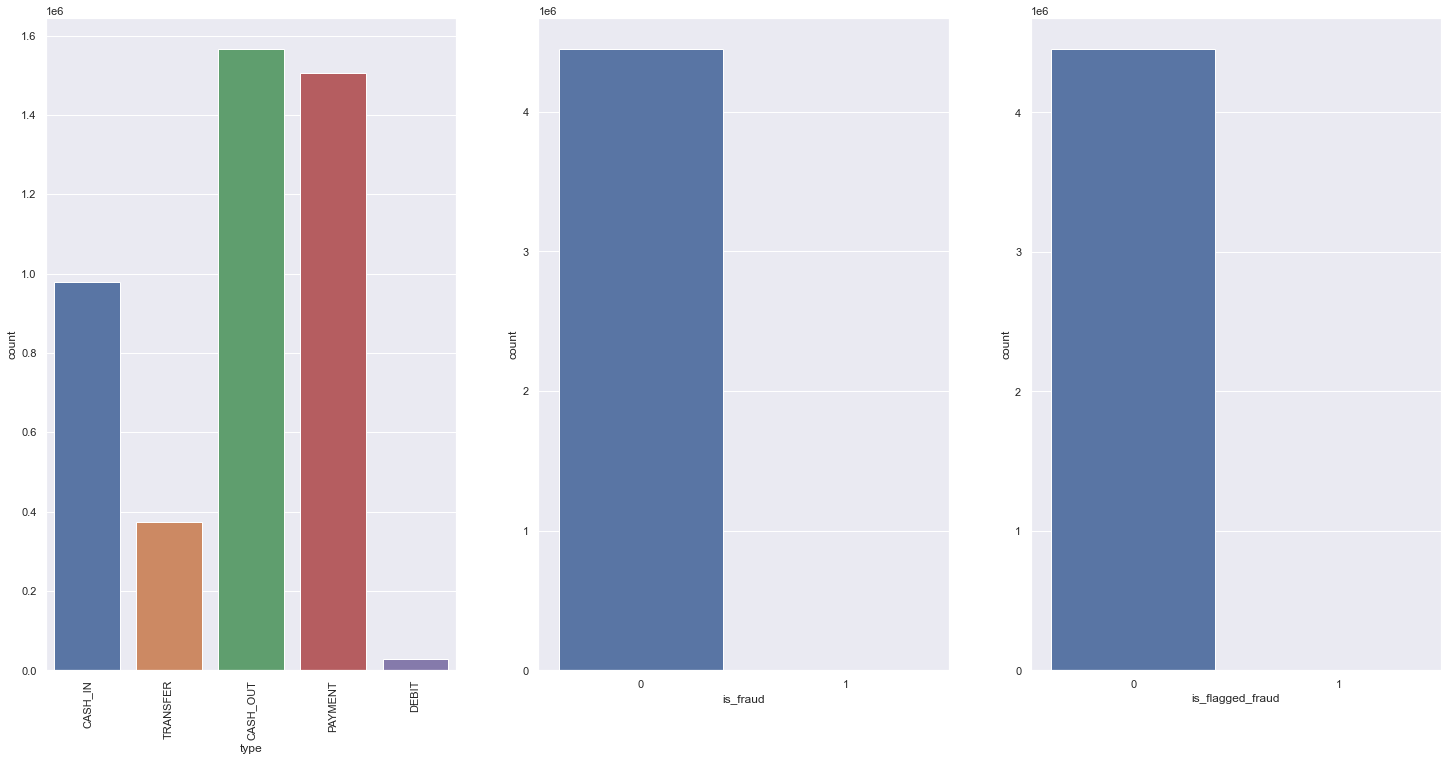

In [22]:
#plt.subplots(figsize = (16, 4))

plt.subplot(1,3,1)
sns.countplot(df1['type'])
plt.xticks(rotation=90)


plt.subplot(1,3,2)
sns.countplot(df1['is_fraud'])

plt.subplot(1,3,3)
sns.countplot(df1['is_flagged_fraud'])

In [23]:
# Check "is_fraud"
print(df1['is_fraud'].value_counts())

#or i in (df1['is_fraud'].value_counts(normalize = True)):
#   print()
    
for idx, val in enumerate(df1['is_fraud'].value_counts(normalize = True)):
    print(f'{idx} : {100*val:.4} %')

0    4448085
1       5749
Name: is_fraud, dtype: int64
0 : 99.87 %
1 : 0.1291 %


In [24]:
# Check "is_flagged_fraud"
print(df1['is_flagged_fraud'].value_counts())

for idx, val in enumerate(df1['is_flagged_fraud'].value_counts(normalize = True)):
    print(f'{idx} : {100*val:.6} %')

0    4453820
1         14
Name: is_flagged_fraud, dtype: int64
0 : 99.9997 %
1 : 0.000314336 %


- It is possible to see that data is highly unbalanced

# 2.0 Feature Engineering

In [18]:
df2 = df1.copy()

## 2.1 Hypothesis mind map

<img src="img/MindMapHypotesis.png">

## 2.2 Hypotheses Creation


### Number of transactions 

**1.** Customers who already had frauds in their transactions are more likely to have fraudulent transactions.

**2.** Sudden changes in a customer's number of transactions per week may indicate a fraudulent transaction

### Flagged fraud

**1.** Transaction that has Fraud flagged is always a fraud

### Transaction type

**1.** Transfer transaction is more likely to be a fraud

### Transaction amount

**1.** The higher the value of the transaction the greater the chance of being fraud.

**2.** Zero-value transactions are more likely to be fraud

### Balance

**1.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)

**2.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)

**3.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.

### Clients

**1.** Transactions received by non-merchants are more likely to be a fraud

### Time

**1.** Transactions made outside normal hours are more likely to be fraud.

**2.** Transactions made on the first 15 days of the month are more likely to be a fraud.










## 2.3 Final hypotheses list



The hypotheses were chosen based on the data that have already been obtained and can be used for study. For other hypotheses to be tested, there needs to be a greater collection of data from different areas of the company.

**1.** Transaction that has Fraud flagged is always a fraud

**2.** Transfer transaction is more likely to be a fraud

**3.** The higher the value of the transaction the greater the chance of being fraud.

**4.** Zero-value transactions are more likely to be fraud

**5.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)

**6.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)

**7.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.

**8.** Transactions received by non-merchants are more likely to be a fraud

**9.** Transactions made outside normal hours are more likely to be fraud.

**10.** Transactions made on the first 15 days of the month are more likely to be a fraud.

## 2.4 Feature Engineering

In [19]:
# step

## outside normal hour  (normal: 7h - 0h, not normal: 0h - 7h)

## hour
df2['hour'] = df2['step'].apply(lambda x: x%24)

df2['outside_normal_hour'] = df2['step'].apply(lambda x: 1 if (0<x<7) else 0 )

## day
df2['day'] = df2['step'].apply(lambda x: int(x/24) + 1)

## week
df2['week'] = df2['day'].apply(lambda x: 1 if (x<=7) else 2 if (x <=14) else 3 if (x <=21) else 4)

# amount
df2['aux_amount'] = df2['type'].apply(lambda x: -1 if x =="CASH_IN" else 1)
df2['amount'] = df2['amount'] * df2['aux_amount']
df2 = df2.drop(columns=['aux_amount'])

df2['amount_is_zero'] = df2['amount'].apply(lambda x: 1 if x == 0 else 0)

#name_orig
df2['client_orig'] = df2['name_orig'].apply(lambda x: 'merchant' if "M" in x else "non-merchant")
df2 = df2.drop(columns=['name_orig'])

#name_dest
df2['client_dest'] = df2['name_dest'].apply(lambda x: "merchant" if "M" in x else "non-merchant")
df2 = df2.drop(columns=['name_dest'])

#difference between old and new balance 
df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),3)

aux1 = df2[df2['client_dest']=='non-merchant'] 

df2['error_balance_dest'] = np.round((aux1['newbalance_dest'] - aux1['amount'] - aux1['oldbalance_dest']),3)
df2.error_balance_dest.fillna(0, inplace=True)

In [20]:
num_attributes_2 = df2.select_dtypes(include=['int64','float64'])
num_attributes_2.columns

Index(['step', 'amount', 'oldbalance_org', 'newbalance_orig',
       'oldbalance_dest', 'newbalance_dest', 'hour', 'outside_normal_hour',
       'day', 'week', 'amount_is_zero', 'error_balance_orig',
       'error_balance_dest'],
      dtype='object')

In [28]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes_2.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_2.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes_2.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_2.apply(min)).T
d3 = pd.DataFrame(num_attributes_2.apply(max)).T
d4 = pd.DataFrame(num_attributes_2.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes_2.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes_2.apply(lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.00,7.430000e+02,7.420000e+02,2.433875e+02,239.000,1.423211e+02,0.375688,0.330202
1,amount,-1915267.90,9.244552e+07,9.436078e+07,1.056327e+05,17345.265,6.193369e+05,28.150161,1551.033463
2,oldbalance_org,0.00,5.958504e+07,5.958504e+07,8.347573e+05,14235.000,2.890121e+06,5.246103,32.936283
3,newbalance_orig,0.00,4.958504e+07,4.958504e+07,8.559756e+05,0.000,2.925904e+06,5.173527,32.024931
4,oldbalance_dest,0.00,3.560159e+08,3.560159e+08,1.100704e+06,132887.905,3.388743e+06,19.454253,898.326761
5,newbalance_dest,0.00,3.561793e+08,3.561793e+08,1.225085e+06,214938.290,3.663795e+06,18.944886,822.224926
6,hour,0.00,2.300000e+01,2.300000e+01,1.532250e+01,16.000,4.321361e+00,-0.606607,0.687026
7,outside_normal_hour,0.00,1.000000e+00,1.000000e+00,1.115443e-03,0.000,3.337962e-02,29.891573,891.506547
8,day,1.00,3.100000e+01,3.000000e+01,1.050271e+01,10.000,5.921731e+00,0.378120,0.332852
9,week,1.00,4.000000e+00,3.000000e+00,1.992622e+00,2.000,8.318361e-01,0.503111,-0.360837


# 3.0 Variable filtering

In [21]:
df3 = df2.copy()

## 3.1 Line filtering

## 3.2 Column selection

# 4.0 Exploratory data analysis

In [22]:
df4 = df3.copy() 

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='is_fraud', ylabel='count'>

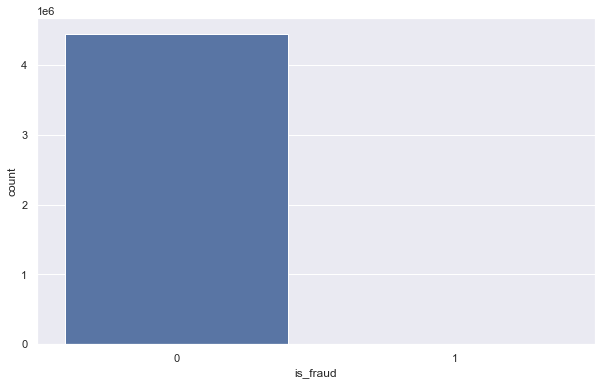

In [31]:
plt.figure(figsize=(10,6))
sns.countplot(x=df4['is_fraud'])

- One more time, we can see that the data is very unbalanced

### 4.1.2 Numerical Variable

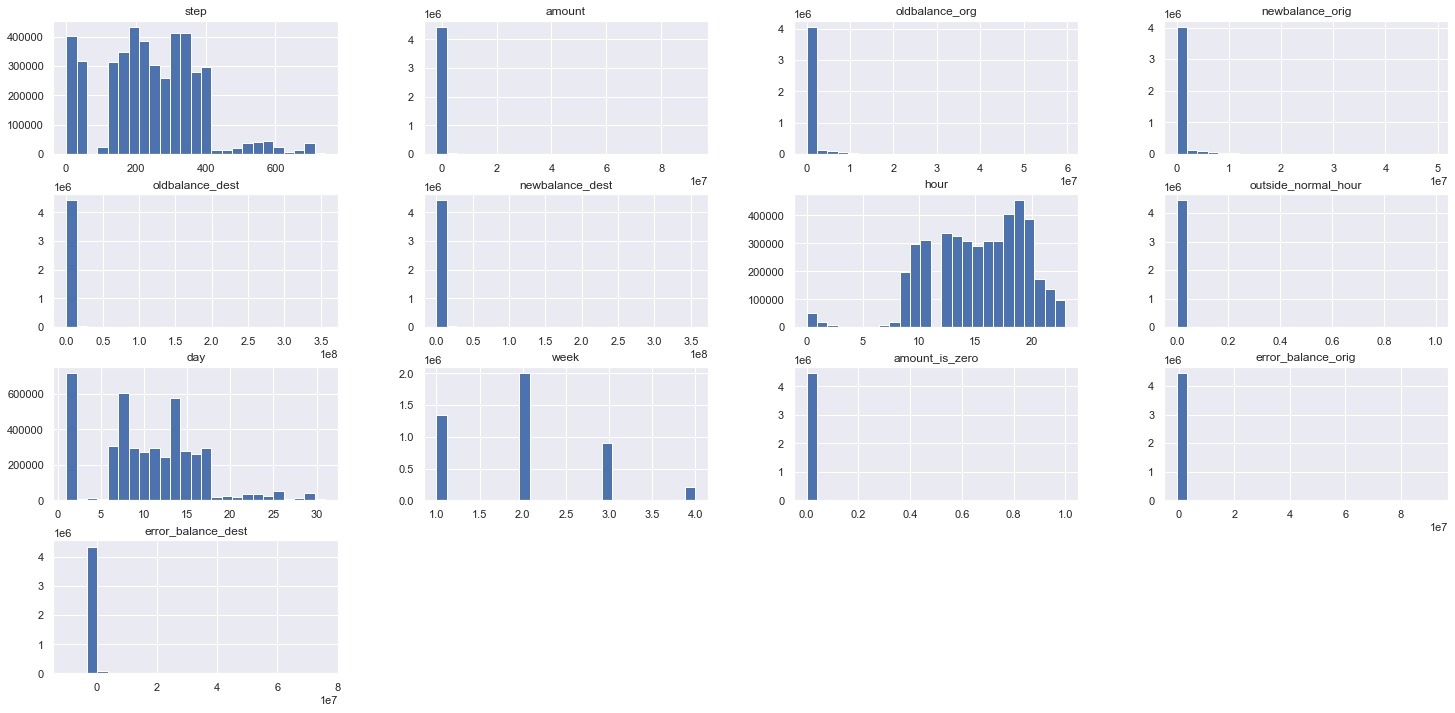

In [32]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
num_attributes.hist(bins = 25);

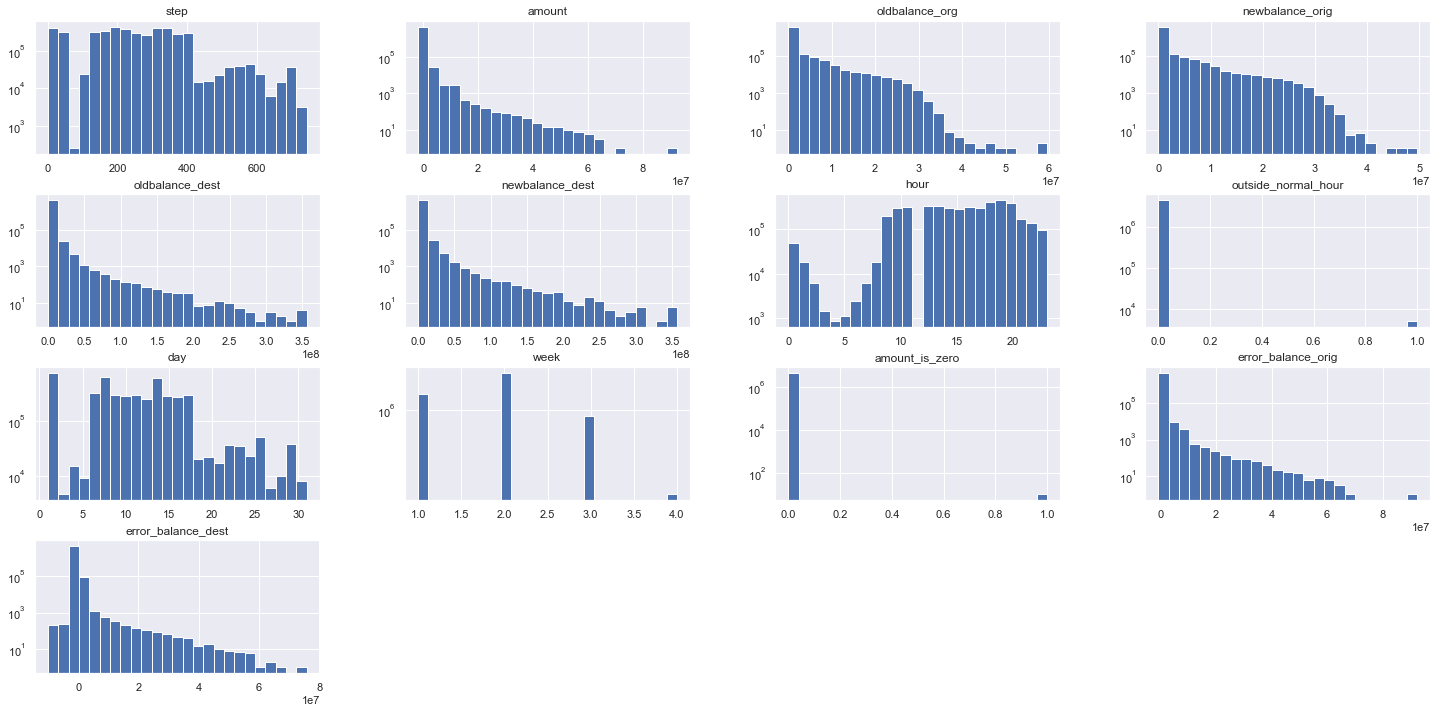

In [33]:
num_attributes = df4.select_dtypes(include = ['int64','float64'])
num_attributes.hist(bins = 25, log=True);

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated 

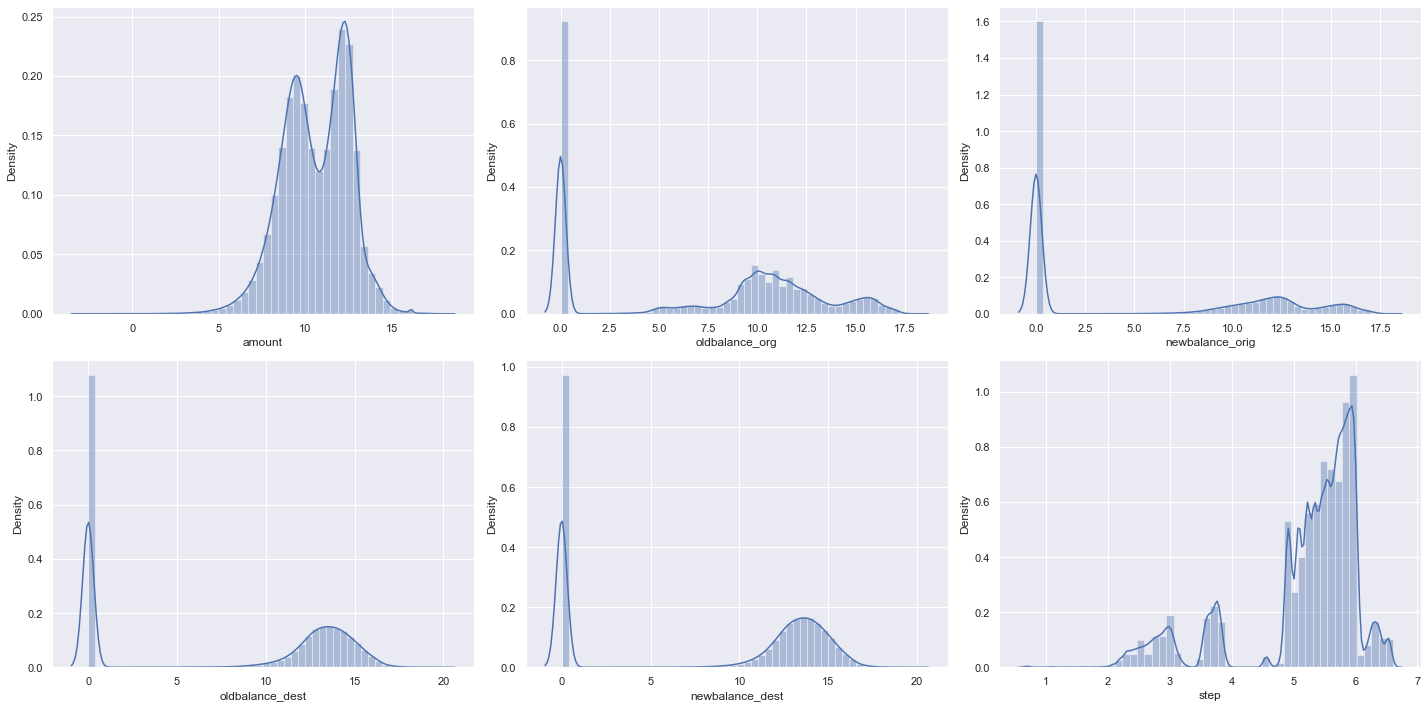

In [34]:
vari = ['amount', 'oldbalance_org','newbalance_orig','oldbalance_dest','newbalance_dest','step']

f, axes = plt.subplots(2, 3, figsize = (20, 10))
for var, ax in zip(vari, f.axes):
    b = sns.distplot(np.log1p(num_attributes[var]), ax = ax)

plt.tight_layout()
plt.show()

img src="img/4.1.2.png"

### 4.1.3 Categorical Variable

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='client_dest', ylabel='count'>

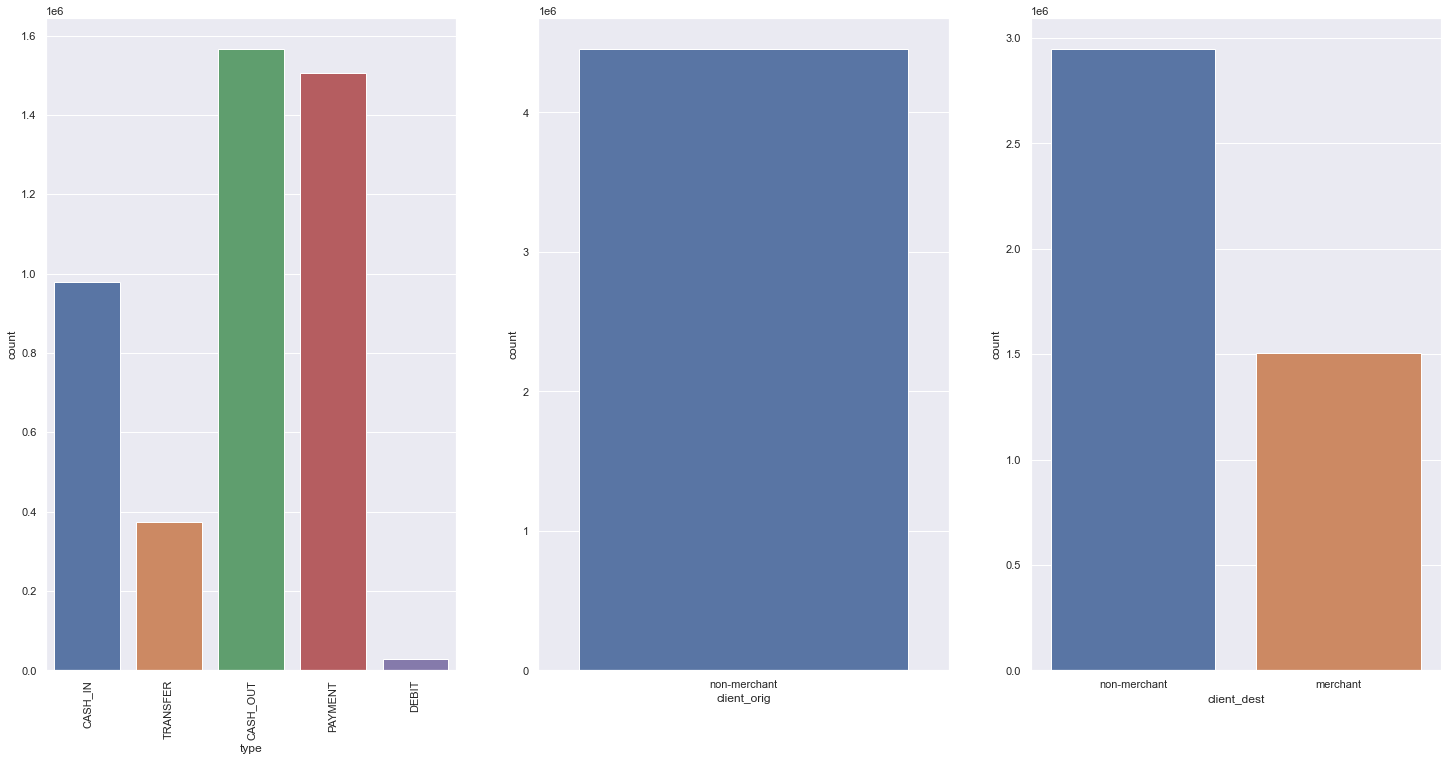

In [35]:
plt.subplot(1,3,1)
sns.countplot(df4['type'])
plt.xticks(rotation=90)


plt.subplot(1,3,2)
sns.countplot(df4['client_orig'])

plt.subplot(1,3,3)
sns.countplot(df4['client_dest'])

Key points:

- The most frequently types of transactions, in ascending order: Debit, Transfer, Cash-in, Payment and Cash-out. 
- Just non-merchant clients do transactions. Merchants only receive.


## 4.2 Bivariate analysis

### **H1** Transaction that has Fraud flagged is always a fraud
**true**


<AxesSubplot:xlabel='is_fraud', ylabel='count'>

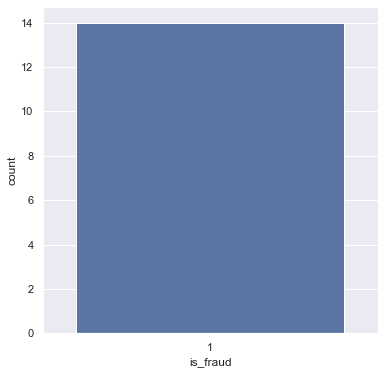

In [36]:
plt.figure(figsize=(6,6))

a=df4[df4['is_flagged_fraud'] == 1]
b=a[['is_flagged_fraud','is_fraud']]
sns.countplot(x='is_fraud',data=b)

In [37]:
a = df4[['is_flagged_fraud','is_fraud']].groupby(['is_fraud']).sum().reset_index()
a

,is_fraud,is_flagged_fraud
0,0,0
1,1,14


### **H2** Transfer transaction is more likely to be a fraud
**false** Only transfer and cash-out transactions are fraudulent. cash-out has 4116 frauds, slightly higher than transfer (4097)

Text(0.5, 1.0, 'Fraud = true')

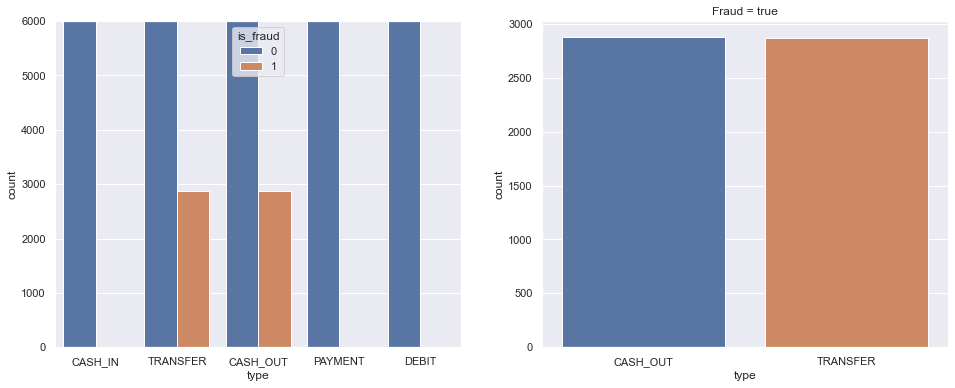

In [38]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='type', data = df4, hue='is_fraud')
ax.set_ylim([0,6000])

plt.subplot(1,2,2)
aux = df4[df4['is_fraud']==1]
ax = sns.countplot(x='type', data = aux)
plt.title("Fraud = true")

In [39]:
aux.type.value_counts()

CASH_OUT    2882
TRANSFER    2867
Name: type, dtype: int64

### **H3** The higher the value of the transaction the greater the chance of being fraud.
**true#** The hypothesis is true, but only in amounts below 10,000,000. Above that amount there aren't cases of fraud.


In [40]:
aux1 = pd.DataFrame()
aux_fraud = pd.DataFrame()
aux_fraud['is_fraud'] = df4['is_fraud']
aux_fraud['is_fraud'] = aux_fraud.is_fraud.astype('int64')*100

bi = list(np.arange(0,100000000,100000))
aux1['amount_binned'] = pd.cut(x = df4['amount'], bins=bi)

aux2 = pd.concat([aux1,aux_fraud],axis=1)
aux3 = aux2.groupby('amount_binned').mean().reset_index()
aux4 = aux3[aux3['is_fraud']>0.0]

In [41]:
aux5 = df4[df4['is_fraud']==1]
aux6 = aux5.sort_values(by=['amount'], ascending=False)
aux6.head(5)

,step,type,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,hour,outside_normal_hour,day,week,amount_is_zero,client_orig,client_dest,error_balance_orig,error_balance_dest
3247292,250,CASH_OUT,10000000.0,10000000.00,0.00,147964.13,10147964.13,1,0,10,0,11,2,0,non-merchant,non-merchant,0.0,0.0
6266411,617,TRANSFER,10000000.0,12542664.27,2542664.27,0.00,0.00,1,0,17,0,26,4,0,non-merchant,non-merchant,0.0,-10000000.0
6074074,516,CASH_OUT,10000000.0,10000000.00,0.00,6070888.20,16070888.20,1,0,12,0,22,4,0,non-merchant,non-merchant,0.0,-0.0
5996399,425,TRANSFER,10000000.0,59585040.37,49585040.37,0.00,0.00,1,0,17,0,18,3,0,non-merchant,non-merchant,0.0,-10000000.0
3610971,269,TRANSFER,10000000.0,13042111.54,3042111.54,0.00,0.00,1,0,5,0,12,2,0,non-merchant,non-merchant,0.0,-10000000.0


the largest amount that is fraud is 10 million

Text(0, 0.5, 'Is Fraud in percentage')

<Figure size 1728x720 with 0 Axes>

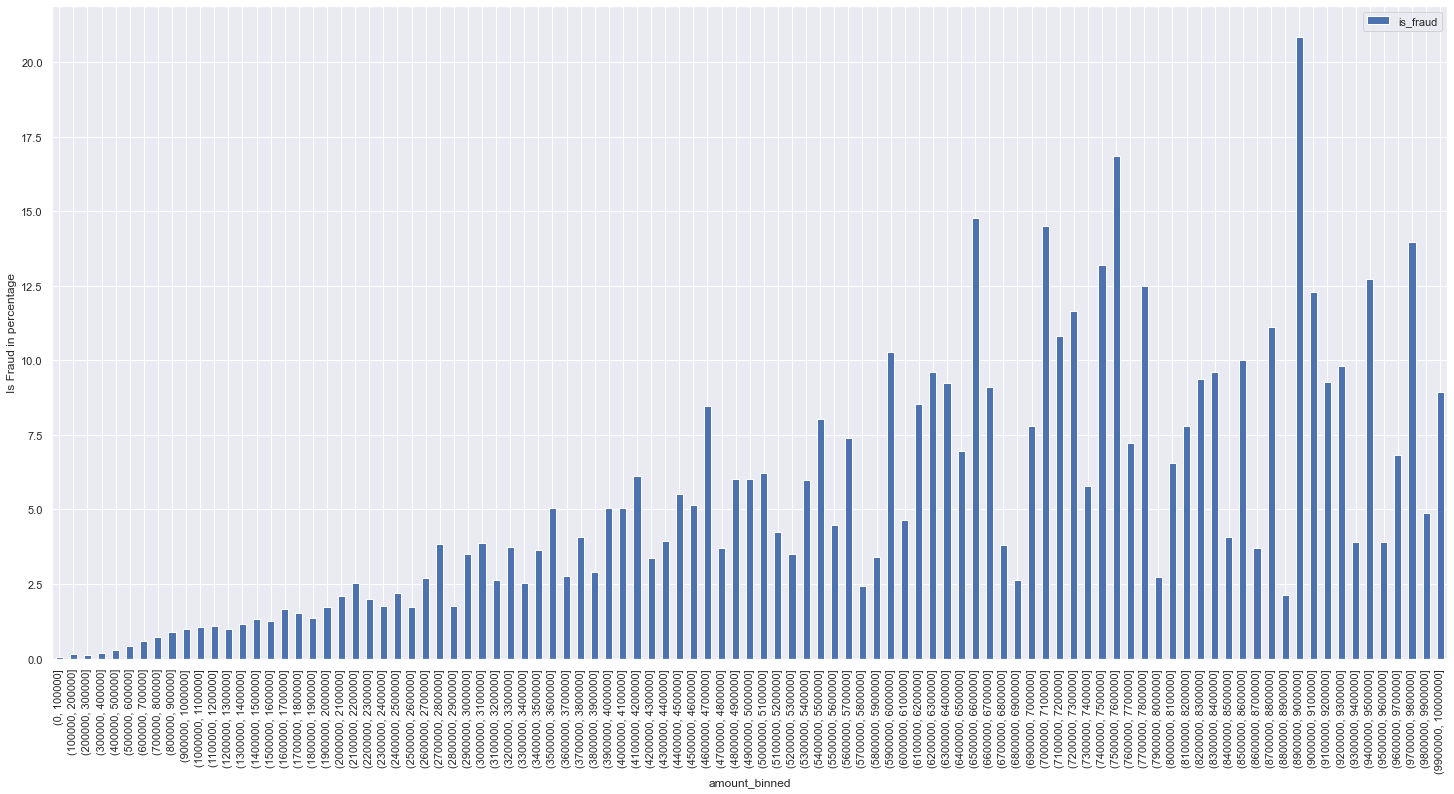

In [42]:
plt.figure(figsize=(24,10))
ax = aux4.plot.bar(x='amount_binned', y='is_fraud')
ax.set_ylabel("Is Fraud in percentage")

<AxesSubplot:>

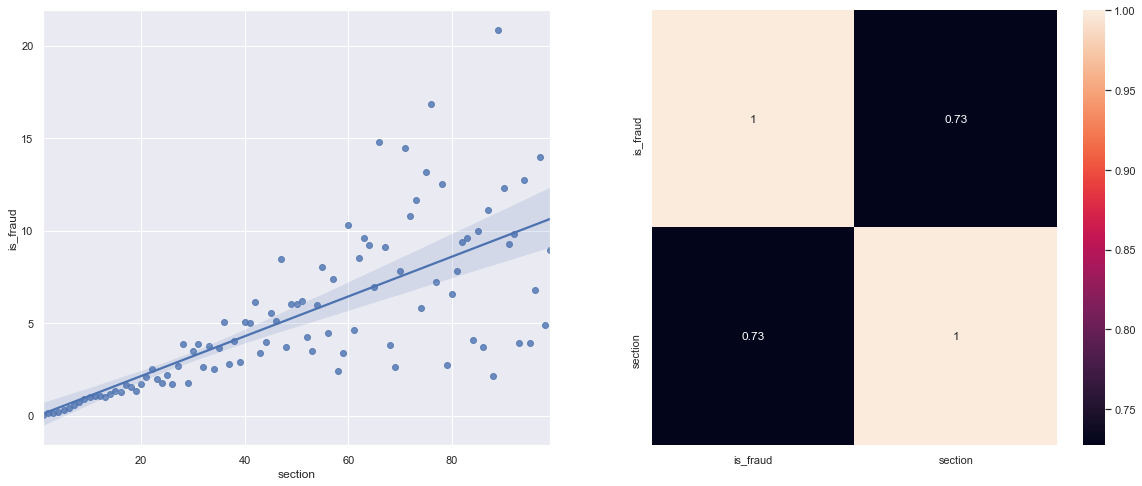

In [43]:
plt.figure(figsize=(20,8))

aux_plot = aux4.drop(columns=["amount_binned"])
aux_plot['section'] = range(1,len(aux4)+1)

plt.subplot(1,2,1)
sns.regplot(x='section', y='is_fraud', data=aux_plot)


plt.subplot(1,2,2)
sns.heatmap(aux_plot.corr(method='pearson'), annot=True)

### **H4.** Zero-value transactions are more likely to be fraud
**true** All zero value transactions are fraud



In [44]:
aux = df4[df4['amount']==0]

print('Number of zero-value transaction:', aux.shape[0] )
print('Number of frauds:', aux.is_fraud.value_counts())


Number of zero-value transaction: 11
Number of frauds: 1    11
Name: is_fraud, dtype: int64


### **H5.** Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)
**False#** There are some frauds in this type of transaction, but they are only 0.00195%.


In [45]:
aux_h5 = df4[df4['oldbalance_org']==0]

print('Transactions whose initial balance is zero:', aux_h5.shape[0] )
print('Number of frauds:')
print(aux_h5.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((41/2102449)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose initial balance is zero: 1471116
Number of frauds:
0    1471088
1         28
Name: is_fraud, dtype: int64
percentage of frauds: 0.00195 %


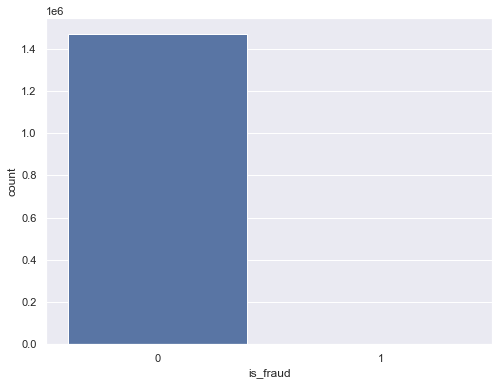

In [46]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='is_fraud', data=aux_h5)

### **H6.** Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)
**true** Transactions with final balance = 0, have 0,22% of frauds while the others have 0,006%

In [47]:
# FINAL BALANCE = 0 
aux_h6 = df4[df4['newbalance_orig']==0]

print('Transactions whose final balance is zero:', aux_h6.shape[0] )
print('Number of frauds:')
print(aux_h6.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8053/3609566)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 2526310
Number of frauds:
0    2520681
1       5629
Name: is_fraud, dtype: int64
percentage of frauds: 0.22310 %


In [48]:
# FINAL BALANCE != 0
aux_h62 = df4[df4['newbalance_orig'] !=0]

print('Transactions whose final balance is zero:', aux_h62.shape[0] )
print('Number of frauds:')
print(aux_h62.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((160/2753054)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 1927524
Number of frauds:
0    1927404
1        120
Name: is_fraud, dtype: int64
percentage of frauds: 0.00581 %


### **H7.** Transactions that differ between the old balance and the new balance are more likely to be fraudulent.
**false** Transactions that have a difference actually have a lower percentage of fraud

In [49]:
# DON'T HAVE DIFFERENCE
aux_h7 = df4[(df4['error_balance_orig'] ==0) | (df4['error_balance_dest']==0)]

print('Transactions whose final balance is zero:', aux_h7.shape[0] )
print('Number of frauds:')
print(aux_h7.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8185/5542790)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 3880073
Number of frauds:
0    3874346
1       5727
Name: is_fraud, dtype: int64
percentage of frauds: 0.14767 %


In [50]:
# HAVE DIFFERENCE
aux_h7 = df4[(df4['error_balance_orig'] !=0) | (df4['error_balance_dest']!=0)]

print('Transactions whose final balance is zero:', aux_h7.shape[0] )
print('Number of frauds:')
print(aux_h7.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4897/4552968)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions whose final balance is zero: 3190449
Number of frauds:
0    3187038
1       3411
Name: is_fraud, dtype: int64
percentage of frauds: 0.10756 %


### **H8.** Transactions received by non-merchants are more likely to be a fraud

**true** 0.19541% of transactions for non-merchant are fraud, while for merchant there is no fraud


In [51]:
aux_h8 = df4[df4['client_dest']=='non-merchant']

print('Transactions :', aux_h8.shape[0] )
print('Number of frauds:')
print(aux_h8.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8213/4202912)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))



Transactions : 2947679
Number of frauds:
0    2941930
1       5749
Name: is_fraud, dtype: int64
percentage of frauds: 0.19541 %


In [52]:
aux_h8 = df4[df4['client_dest']=='merchant']

print('Transactions :', aux_h8.shape[0] )
print('Number of frauds:')
print(aux_h8.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % (0), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions : 1506155
Number of frauds:
0    1506155
Name: is_fraud, dtype: int64
percentage of frauds: 0.00000 %


### **H9.** Transactions made outside normal hours are more likely to be fraud. (normal: 7h - 0h, not normal: 0h - 7h)
**true** 


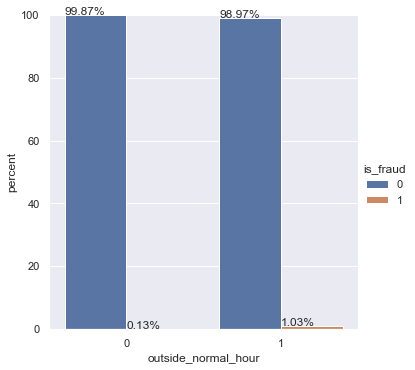

In [53]:
x,y = 'outside_normal_hour', 'is_fraud'

df = df4.groupby(x)[y].value_counts(normalize=True)
df = df.mul(100)
df = df.rename('percent').reset_index()

g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df)
g.ax.set_ylim(0,100)

for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [54]:
aux_h9 = df4[df4['outside_normal_hour']==1]

print('Transactions :', aux_h9.shape[0] )
print('Number of frauds:')
print(aux_h9.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((66/7164)*100), '%')
#print('percentage of frauds {0:.5f} %'.format((41/2102449)*100))

Transactions : 4968
Number of frauds:
0    4917
1      51
Name: is_fraud, dtype: int64
percentage of frauds: 0.92127 %


In [55]:
aux_h9 = df4[df4['outside_normal_hour']!=1]

print('Transactions:', aux_h9.shape[0] )
print('Number of frauds:')
print(aux_h9.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((8147/6355456)*100), '%')

Transactions: 4448866
Number of frauds:
0    4443168
1       5698
Name: is_fraud, dtype: int64
percentage of frauds: 0.12819 %


### **H10.** Transactions made on the first 15 days of the month are more likely to be a fraud.
**false** The amount of fraud in the second half of the month is lower, but the percentage is higher, due to the number of transactions that decreases over the month


<AxesSubplot:>

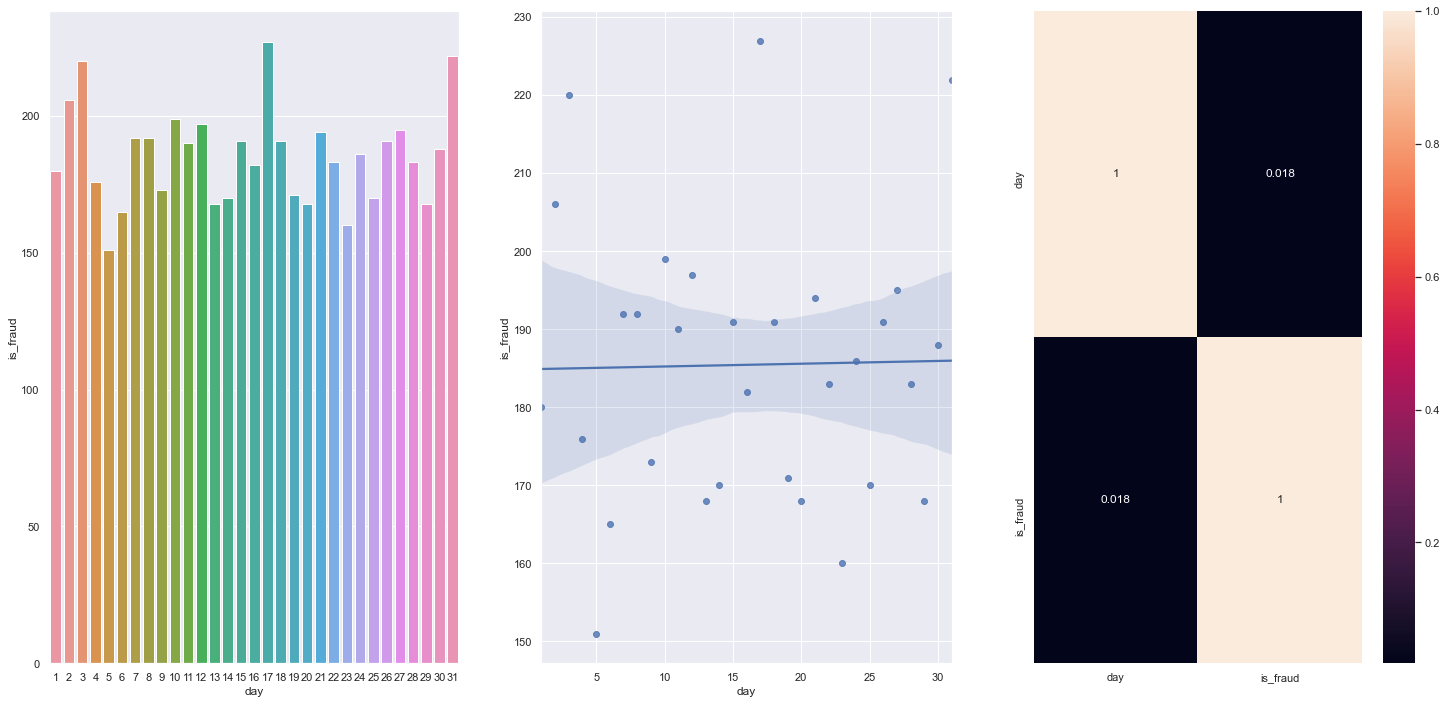

In [56]:
aux1 = df4[['is_fraud','day']].groupby(['day']).sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day', y='is_fraud', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day', y='is_fraud', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

In [57]:
#FIRST 15 DAYS

aux_h10 = df4[df4['day']<=15]

print('Transactions:', aux_h10.shape[0] )
print('Number of frauds:')
print(aux_h10.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4009/5178540)*100), '%')

Transactions: 3628059
Number of frauds:
0    3625289
1       2770
Name: is_fraud, dtype: int64
percentage of frauds: 0.07742 %


In [58]:
#LAST 16 DAYS

aux_h10 = df4[df4['day']>=16]

print('Transactions:', aux_h10.shape[0] )
print('Number of frauds:')
print(aux_h10.is_fraud.value_counts())
print('percentage of frauds:', "%.5f" % ((4204/1175867)*100), '%')

Transactions: 825775
Number of frauds:
0    822796
1      2979
Name: is_fraud, dtype: int64
percentage of frauds: 0.35752 %


### 4.2.1 Summary of hypotheses

In [59]:
tab = [['hypotheses', 'conclusion', 'relevance',''],
        ['H1', 'True', 'High','Transaction that has Fraud flagged is always a fraud'],
        ['H2', 'False', 'High','Transfer transaction is more likely to be a fraud'],
        ['H3', 'True', 'Medium','The higher the value of the transaction the greater the chance of being fraud.'],
        ['H4', 'True', 'High','Zero-value transactions are more likely to be fraud'],
        ['H5', 'False', 'Medium','Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)'],
        ['H6', 'True', 'High','Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)'],
        ['H7', 'False', 'Low','Transactions that differ between the old balance and the new balance are more likely to be fraudulent.'],
        ['H8', 'True', 'Low','Transactions made and received by non-merchants are more likely to be a fraud'],
        ['H9', 'True', 'Low','Transactions made outside normal hours are more likely to be fraud. (normal: 7h - 0h, not normal: 0h - 7h)'],
        ['H10', 'False', 'Low','Transactions made on the first 15 days of the month are more likely to be a fraud.'],
     ]

print (tabulate (tab, headers = 'firstrow'))

hypotheses    conclusion    relevance
------------  ------------  -----------  --------------------------------------------------------------------------------------------------------------
H1            True          High         Transaction that has Fraud flagged is always a fraud
H2            False         High         Transfer transaction is more likely to be a fraud
H3            True          Medium       The higher the value of the transaction the greater the chance of being fraud.
H4            True          High         Zero-value transactions are more likely to be fraud
H5            False         Medium       Transactions whose initial balance is zero is never a fraud. (balance that started the transaction)
H6            True          High         Transactions whose final balance is zero are more likely to be a fraud. (balance that started the transaction)
H7            False         Low          Transactions that differ between the old balance and the new balance are more 

## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

In [60]:
aux = num_attributes.copy()
aux['is_fraud'] = df4['is_fraud']
aux['is_flagged_fraud'] = df4['is_flagged_fraud']

aux['is_fraud'] = aux.is_fraud.astype('int64')
aux['is_flagged_fraud'] = aux.is_flagged_fraud.astype('int64')


<AxesSubplot:>

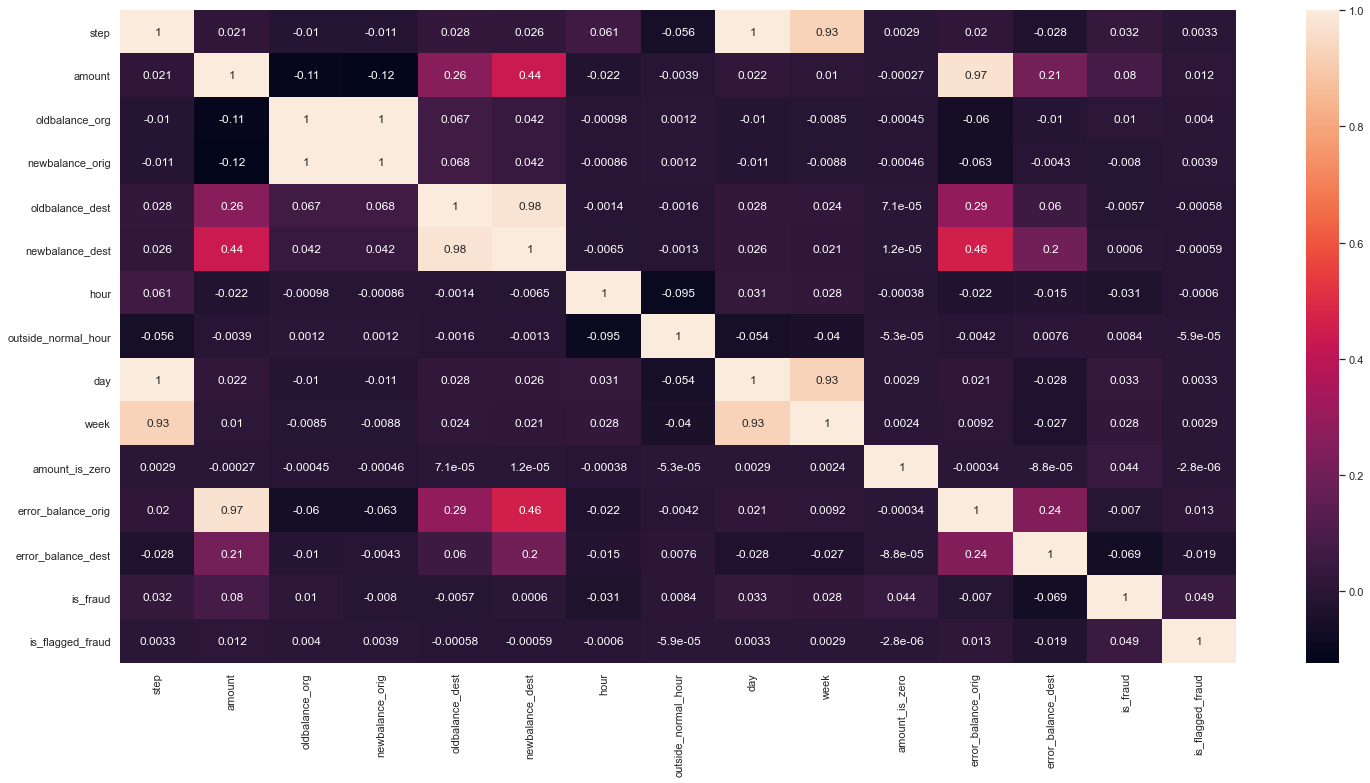

In [61]:
correlation = aux.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

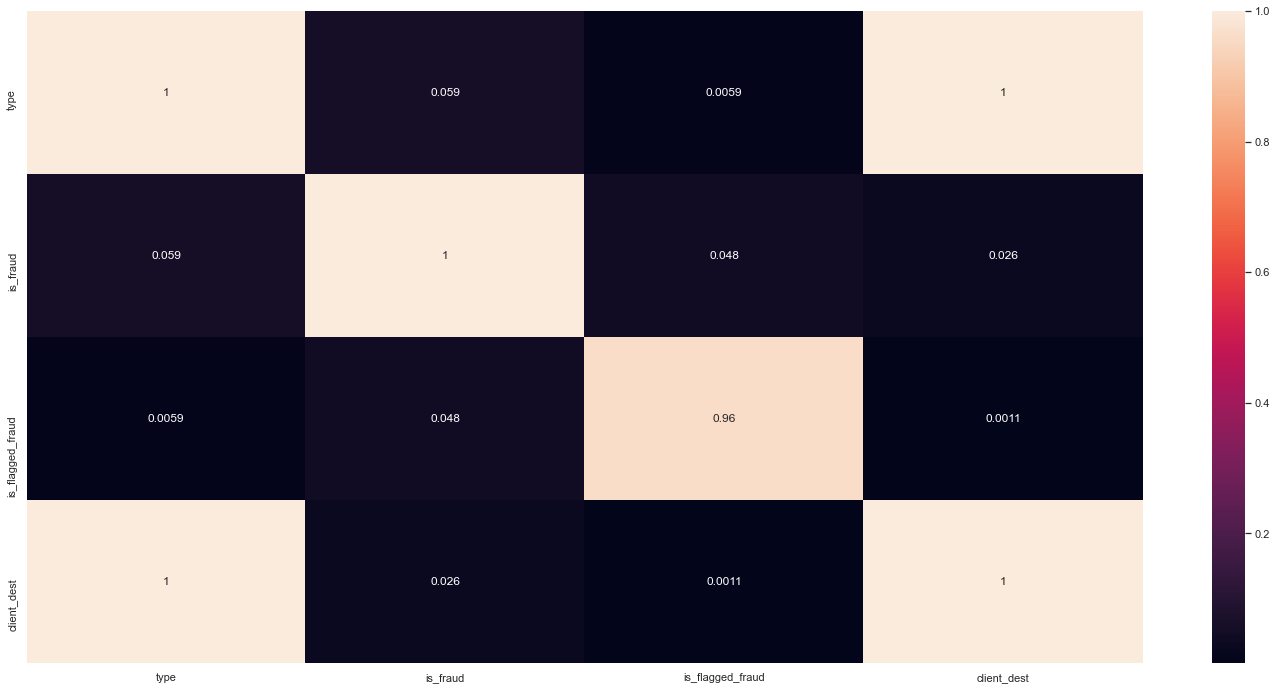

In [62]:
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['type'], a['type'])
a2 = cramer_v(a['type'], a['is_fraud'])
a3 = cramer_v(a['type'], a['is_flagged_fraud'])
a4 = cramer_v(a['type'], a['client_dest'])

a5 = cramer_v(a['is_fraud'], a['type'])
a6 = cramer_v(a['is_fraud'], a['is_fraud'])
a7 = cramer_v(a['is_fraud'], a['is_flagged_fraud'])
a8 = cramer_v(a['is_fraud'], a['client_dest'])

a9 = cramer_v(a['is_flagged_fraud'], a['type'])
a10 = cramer_v(a['is_flagged_fraud'], a['is_fraud'])
a11 = cramer_v(a['is_flagged_fraud'], a['is_flagged_fraud'])
a12 = cramer_v(a['is_flagged_fraud'], a['client_dest'])

a13 = cramer_v(a['client_dest'], a['type'])
a14 = cramer_v(a['client_dest'], a['is_fraud'])
a15 = cramer_v(a['client_dest'], a['is_flagged_fraud'])
a16 = cramer_v(a['client_dest'], a['client_dest'])

d = pd.DataFrame({'type':[a1,a2,a3,a4],
              'is_fraud':[a5,a6,a7,a8],
              'is_flagged_fraud':[a9,a10,a11,a12],
              'client_dest':[a13,a14,a15,a16]})

d = d.set_index(d.columns)

sns.heatmap(d, annot = True);

- Client_orig was not included because it only has one type
- It is interesting to see that the type and the clien_dest have a very strong correlation

# 5.0 Data Preparation

In [23]:
df5 = df4.copy()

## 5.1 Normalization



Observing the distributions of the numerical variables in 4.1.2, it is visible that none has a distribution close to normal, thus it would negatively affect normalization

## 5.2 Rescaling

In [24]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,hour,outside_normal_hour,day,week,amount_is_zero,error_balance_orig,error_balance_dest
4310249,308,-260485.23,32371.00,292856.23,4633560.35,4373075.12,20,0,13,2,0,-0.00,0.00
318938,16,1387060.19,432673.78,0.00,0.00,1033440.62,16,0,1,1,0,954386.41,-353619.57
3375139,254,1140661.98,59947.00,0.00,15000.85,1155662.83,14,0,11,2,0,1080714.98,0.00
5492781,380,-169390.39,80047.10,249437.49,1467039.66,1297649.27,20,0,16,3,0,-0.00,0.00
807263,40,-4867.26,5989226.14,5994093.40,1609385.28,1604518.02,16,0,2,1,0,0.00,0.00


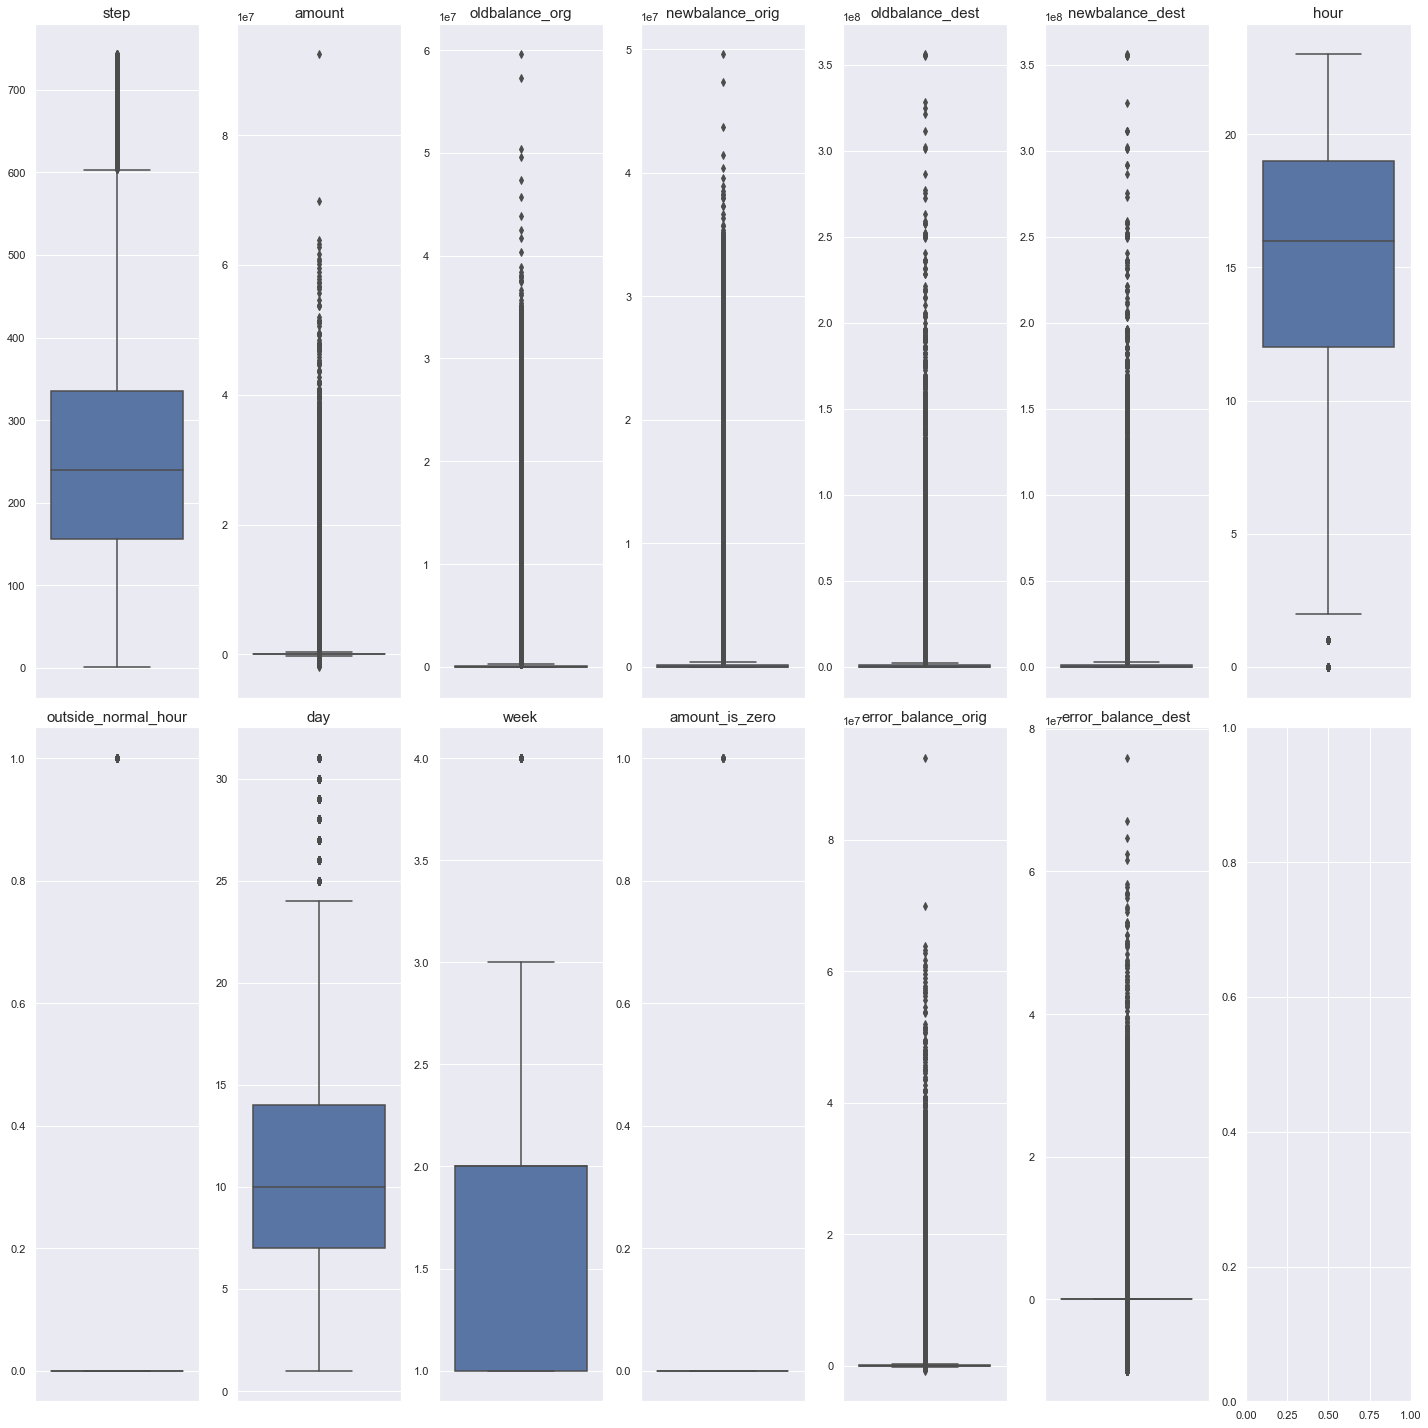

In [65]:
variables = a.columns.tolist()

f, axes = plt.subplots(2, 7, figsize = (20, 20))
for var, ax in zip(variables, f.axes):
    b = sns.boxplot(y = var, data = a, ax = ax)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")
plt.tight_layout()
plt.show()

In [25]:
rs = RobustScaler()

# amount
df5['amount'] = rs.fit_transform(df5[['amount']])
pickle.dump(rs, open("parameter/scaler_amount.pkl",'wb'))


# oldbalance_org
df5['oldbalance_org'] = rs.fit_transform(df5[['oldbalance_org']])
pickle.dump(rs, open("parameter/scaler_oldbalance_org.pkl",'wb'))

# new balance_orig
df5['newbalance_orig'] = rs.fit_transform(df5[['newbalance_orig']])
pickle.dump(rs, open("parameter/scaler_newbalance_orig.pkl",'wb'))

# oldbalance_dest
df5['oldbalance_dest'] = rs.fit_transform(df5[['oldbalance_dest']])
pickle.dump(rs, open("parameter/scaler_oldbalance_dest.pkl",'wb'))

# newbalance_dest
df5['newbalance_dest'] = rs.fit_transform(df5[['newbalance_dest']])
pickle.dump(rs, open("parameter/scaler_newbalance_dest.pkl",'wb'))

# error_balance_orig
df5['error_balance_orig'] = rs.fit_transform(df5[['error_balance_orig']])
pickle.dump(rs, open("parameter/scaler_error_balance_orig.pkl",'wb'))

# error_balance_dest
df5['error_balance_dest'] = rs.fit_transform(df5[['error_balance_dest']])
pickle.dump(rs, open("parameter/scaler_error_balance_dest.pkl",'wb'))


mms = MinMaxScaler()

# step
df5['step'] = mms.fit_transform(df5[['step']])
pickle.dump(mms, open("parameter/scaler_step.pkl",'wb'))

# day
df5['day'] = mms.fit_transform(df5[['day']])
pickle.dump(mms, open("parameter/scaler_day.pkl",'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [26]:
types = {"CASH_IN":0,'CASH_OUT':1,'DEBIT':2,'PAYMENT':3,'TRANSFER':4}
clients = {'non-merchant':'0','merchant':1}

# Ordinal Encoding
df5['type'] = df5['type'].map(types)
df5['client_orig'] = df5['client_orig'].map(clients)
df5['client_dest'] = df5['client_dest'].map(clients)



### 5.3.3 Nature Transformation

In [27]:
#hour 
df5['hour_sin'] = df5['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
df5['hour_cos'] = df5['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
df5 = df5.drop(columns=['hour'])

# 6.0 Feature Selection

In [28]:
df6=df5.copy()

In [29]:
# It's necessary convert to int
df6['is_fraud'] = df6['is_fraud'].convert_dtypes(convert_integer=True)
df6['is_fraud'] = df6['is_fraud'].astype('int64')
df6['is_flagged_fraud'] = df6['is_flagged_fraud'].convert_dtypes(convert_integer=True)
df6['is_flagged_fraud'] = df6['is_flagged_fraud'].astype('int64')

In [76]:
#split data
X = df6.drop(columns = 'is_fraud', axis = 1)
y = df6['is_fraud']

## 6.1 Random Forest as feature selector

In [87]:
#rf_model = RandomForestClassifier(n_jobs = -1)
#rf_model.fit(X, y)

#random_forest = pd.Series(rf_model.feature_importances_, index=X.columns)
#random_forest.sort_values().plot(kind='barh')

<img src="img/6.1.png">

## 6.2 Boruta as feature selector

In [88]:

## training and test dataset for Boruta
#X_train_n = X.values
#y_train_n = y.ravel() #vectorize

## define ExtraTreeClassifier
#ex_model = ExtraTreesClassifier(n_jobs=-1)

## define Boruta
#boruta = BorutaPy(ex_model, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best features from boruta

In [89]:
#cols_selected = boruta.support_.tolist()
## best features
#cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
#cols_selected_boruta

In [90]:
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X.columns, cols_selected_boruta))
#cols_not_selected_boruta

In [91]:
cols_selected_boruta = ['step',
 'type',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'day',
 'error_balance_orig',
 'error_balance_dest',
 'hour_sin',
 'hour_cos']

cols_not_selected_boruta = ['amount_is_zero',
 'client_dest',
 'client_orig',
 'is_flagged_fraud',
 'outside_normal_hour',
 'week']

## 6.3 Manual Feature Selection

In [30]:
cols_selected_boruta = ['step',
 'type',
 'amount',
 'oldbalance_org',
 'newbalance_orig',
 'oldbalance_dest',
 'newbalance_dest',
 'day',
 'error_balance_orig',
 'error_balance_dest',
 'hour_sin',
 'hour_cos',
 'amount_is_zero', #added
 'is_flagged_fraud' #added
]

# columns to add
feat_to_add = ['is_fraud']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [31]:
df6 = df6[cols_selected_boruta_full]

# 7.0 Balancing Data

In [32]:
df7 = df6.copy()

## 7.1 Split dataframe into training and test dataset

In [33]:
#target variable and features split 
X = df7.drop(columns = 'is_fraud',axis = 1)
y = df7['is_fraud']

#train and test split
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y)

In [113]:
y_train.shape[0]

3117683

In [114]:
y_train.value_counts()  

0    3113659
1       4024
Name: is_fraud, dtype: int64

## 7.2 Balance data

SMOTE-Tomek Links combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class (that is, samples of data from the majority class that is closest with the minority class data). 

SMOTE:

Choose random data from the minority class.
Calculate the Euclidean distance between the random data and its k nearest neighbors.
Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
Repeat the procedure until the desired proportion of minority class is met.
This method is effective because the synthetic data that are generated are relatively close with the feature space on the minority class, thus adding new “information” on the data, unlike the original oversampling method.

TOMEK LINK:

This method can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data (i.e. the data from the majority class that is closest with the minority class data, thus make it ambiguous to distinct), and then remove it.


In [81]:
#Resample
#smote = os.SMOTE(random_state = 42)
#smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),random_state=42)

In [56]:

#list= [0,100000,200000,300000,400000,500000,600000,700000,800000,900000,1000000,
#         1100000,1200000,1300000,1400000,1500000,1600000,1700000,1800000,1900000,2000000,
#         2100000,2200000,2300000,2400000,2500000,2600000,2700000,2800000,2900000,3000000,3117683]
#
#
#dataframe1 = pd.DataFrame()
#dataframe2 = pd.DataFrame()
#
#for i in range(0,31):
#    TesteX = X_train[list[i]:list[i+1]]
#    TesteY = y_train[list[i]:list[i+1]]
#    
#    smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),random_state=42)
#    x_smotetl, y_smotetl = smt.fit_resample(TesteX, TesteY)
#    
#    frames1 = [dataframe1,x_smotetl]
#    dataframe1 = pd.concat(frames1)
#    
#    frames2 = [dataframe2,y_smotetl]
#    dataframe2 = pd.concat(frames2)  

In [118]:
dataframe2.value_counts()  

1.0    3113659
0.0    3077473
dtype: int64

In [121]:
X_train = dataframe1
y_train = dataframe2

# 8.0 Machine Learning Modelling

In [122]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.2 Logistic Regression

Let $𝑌_𝑖$, 𝑖 = 1, … , 𝑛 the binary variable defined by

$$
Y_i = \left\{\begin{matrix}
1, & fraud \\ 
0, & not fraud 
\end{matrix}\right.
$$

with 𝑛 = 4.448.056 being the number of transactions.
To formulate our model we assume that this variable follows a
Bernoulli distribution denoted by $𝑌_𝑖$ ∼ 𝐵𝑒𝑟𝑛𝑜𝑢𝑙𝑙𝑖($𝜇_𝑖$), which takes on two values 0 and
1, being 1 for frauds and 0 otherwise, with probability 𝜇𝑖 ∈ [0,1].

The binary model says that,
$𝑌_𝑖$ ∼ 𝐵𝑒𝑟𝑛𝑜𝑢𝑙𝑙𝑖(𝜇𝑖)
with
𝜇𝑖 = 𝐹(𝜂𝑖) = 𝐹($x_{i}^{T}𝛽$), 𝑖 = 1, … , 𝑛

where the proposed model is called the binary model. This model is a model of
classification that is part of the so-called generalized linear models. 
Binding the binary model with a function logit link.

• Random component: $𝑦_1$, . . . , $𝑦_{4.448.056}$ is a random sample 𝑌𝑖 ∼ 𝐵𝑒𝑟𝑛𝑜𝑢𝑙𝑙𝑖(𝜇𝑖)
• Systematic component: 𝜂𝑖 = 𝛽0 + 𝛽1 ⋅ Variable 1 + 𝛽2 ⋅ Variable 2 + ...
• Link function
$$
logit(\mu _i) = ln(\frac{\mu_i}{1-\mu_i}) 
$$

or

$$
\eta _i = log(\frac{\mu_i}{1-\mu_i}) = x_{i}^{T}\beta , i = 1,...,4.448.056
$$

Considering an accumulated distribution function of the logistic distribution, we have the function of
Logito connection, where the model is

$$
\mu_i = F(\eta _i) = \frac{exp(\eta _i)}{1+exp(\eta _i)} = \frac{exp(\beta_o + \beta_1x_1+...)}{1+exp(\beta_o + \beta_1x_1+...)}
$$

Using the scikit-learn library to create the model:

Another point of the model is the use of l2 Regularization, or Ridge. It changes the model's cost function by adding a bit of bias, but decreasing the risk of overfitting.

In [123]:
# Model
lr = LogisticRegression(n_jobs = -1, random_state=42)

# train
lr.fit(x_train.values, y_train.values)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = pd.DataFrame(["Logistic Regression Classifier",accuracy_score(y_test,yhat_lr), f1_score(y_test,yhat_lr),recall_score(y_test,yhat_lr),
                           precision_score(y_test,yhat_lr)]).T
lr_result.columns = ["Model",'Accuracy',"F1-Score","Recall","Precision_score"]
lr_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Model,Accuracy,F1-Score,Recall,Precision_score
0,Logistic Regression Classifier,0.956045,0.0507201,0.909565,0.0260874


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

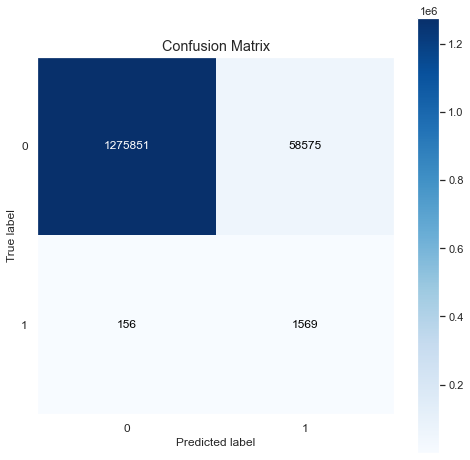

In [124]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lr, normalize = False, figsize = (8,8))

### 7.2.1 Logistic Regression - Cross Validation

In [125]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

lr_result_cv = cross_validate( lr,x_train.values, y_train.values,scoring=scoring ,n_jobs= -1 )

In [126]:
results_cv(lr_result_cv)

,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
0,0.90955 +/- 0.05048619,0.910834 +/- 0.04548042,0.902171 +/- 0.01829539,0.921363 +/- 0.07158134


## 7.3 Light GBM

Light GBM is a gradient boosting framework that uses tree based learning algorithm. (Boosting is an ensemble technique that learns from previous predictor mistakes to make better predictions in the future. The technique combines several weak base learners to form one strong learner, thus significantly improving the predictability of models.) 

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

This is a algoritm that have a high speed and can handle the large size of data and takes lower memory to run


In [127]:
# Model
lgbm = LGBMClassifier(n_jobs = -1, random_state=42)

# train
lgbm.fit(x_train.values, y_train.values)

# prediction
yhat_lgbm = lgbm.predict(x_test)

# performance
lgbm_result = pd.DataFrame(["LGBM Classifier",accuracy_score(y_test,yhat_lgbm), f1_score(y_test,yhat_lgbm),recall_score(y_test,yhat_lgbm),
                           precision_score(y_test,yhat_lgbm)]).T
lgbm_result.columns = ["Model",'Accuracy',"F1-Score","Recall","Precision_score"]
lgbm_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Model,Accuracy,F1-Score,Recall,Precision_score
0,LGBM Classifier,0.999982,0.993064,0.995942,0.990202


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

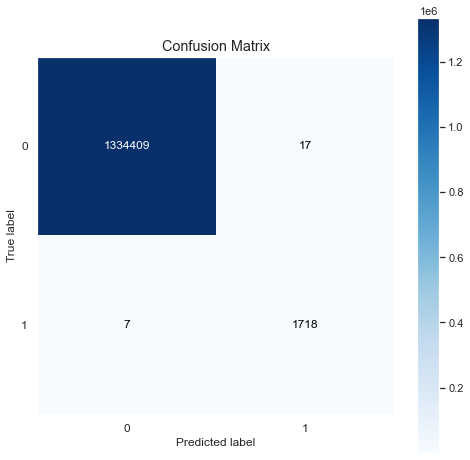

In [128]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_lgbm, normalize = False, figsize = (8,8))

### 7.3.1 Light GBM - Cross Validation

In [129]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

lgbm_result_cv = cross_validate( lgbm,x_train.values, y_train.values,scoring=scoring ,n_jobs= -1 )

In [130]:
results_cv(lgbm_result_cv)

,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
0,0.99891 +/- 0.00083502,0.998914 +/- 0.0008326,0.99785 +/- 0.00163622,0.999982 +/- 2.56e-05


## 7.4 Random Forest Classifier

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

In [131]:
# Model
rf = RandomForestClassifier(n_jobs = -1, random_state=42,n_estimators=100)

In [132]:
# train
rf.fit(x_train.values, y_train.values)

<ipython-input-132-4b4c107a438d>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train.values, y_train.values)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [133]:
# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = pd.DataFrame(["Random Forest Classifier",accuracy_score(y_test,yhat_rf), f1_score(y_test,yhat_rf),recall_score(y_test,yhat_rf),
                           precision_score(y_test,yhat_rf)]).T
rf_result.columns = ["Model",'Accuracy',"F1-Score","Recall","Precision_score"]
rf_result

,Model,Accuracy,F1-Score,Recall,Precision_score
0,Random Forest Classifier,0.999993,0.997388,0.995942,0.998837


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

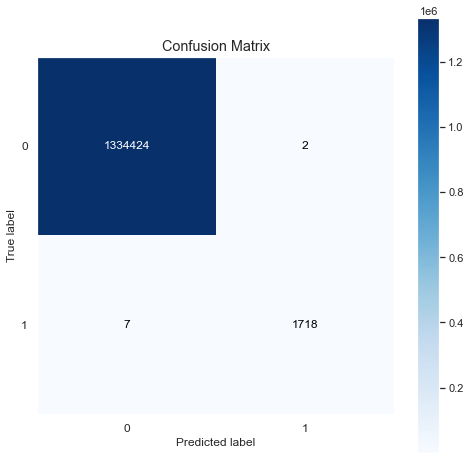

In [134]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_rf, normalize = False, figsize = (8,8))

### 7.4.1 Random Forest classifier- Cross Validation

In [135]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

rf_result_cv = cross_validate( rf,x_train.values, y_train.values,scoring=scoring ,n_jobs= -1 )

In [136]:
results_cv(rf_result_cv)

,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
0,0.998138 +/- 0.00075977,0.998145 +/- 0.00075875,0.9963 +/- 0.00150975,0.999998 +/- 1.44e-06


## 7.5 XGBoost Classifier

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library

For xgboost, the number of trees and the learning rate are two examples of hyper-parameters which require tuning. Both have a strong effect on the model.


In [137]:
# Model
xb = xgb.XGBClassifier(seed=42,
                       objective='reg:squarederror',
                       n_estimators=100, 
                       eta=0.01, 
                       max_depth=10, 
                       subsample=0.7,
                       colsample_bytree=0.9)
                       
# train
xb.fit(x_train.values, y_train.values)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='reg:squarederror', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.7,
              tree_method='approx', validate_parameters=1, verbosity=None)

In [138]:
# prediction
yhat_xb = xb.predict(x_test.values)

# performance
xb_result = pd.DataFrame(["XGBoost Classifier",accuracy_score(y_test,yhat_xb), f1_score(y_test,yhat_xb),recall_score(y_test,yhat_xb),
                           precision_score(y_test,yhat_xb)]).T
xb_result.columns = ["Model",'Accuracy',"F1-Score","Recall","Precision_score"]
xb_result

,Model,Accuracy,F1-Score,Recall,Precision_score
0,XGBoost Classifier,0.999362,0.800842,0.993043,0.670975


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

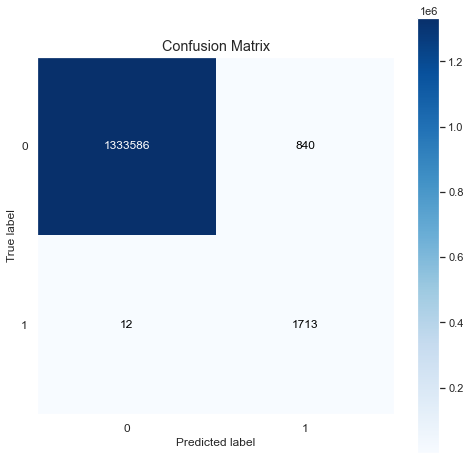

In [139]:
#confusion matrix
mt.plot_confusion_matrix(y_test, yhat_xb, normalize = False, figsize = (8,8))

### 7.5.1 XGBoost Regressor - Cross Validation

In [140]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

xb_result_cv = cross_validate(xb,x_train.values, y_train.values,scoring=scoring  )
results_cv(xb_result_cv)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
0,0.997808 +/- 0.00083372,0.997816 +/- 0.00083243,0.996298 +/- 0.00165199,0.999341 +/- 0.00015097


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [145]:



modelling_result = pd.DataFrame(np.array([['Logistic Regression Classifier',0.956045,0.0507201,0.909565,0.0260874], 
                                          ['LGBM Classifier',0.999982,0.993064,0.995942,0.990202],
                                          ['Random Forest Classifier',0.999993,0.997122,0.995893,0.998353],
                                          ['XGBoost Classifier',0.999362,0.800842,0.993043,0.670975]]),
                   columns=['Model','Accuracy','F1-Score','Recall','Precision_score'])
modelling_result.sort_values('Recall', ascending = False)

,Model,Accuracy,F1-Score,Recall,Precision_score
1,LGBM Classifier,0.999982,0.993064,0.995942,0.990202
2,Random Forest Classifier,0.999993,0.997122,0.995893,0.998353
3,XGBoost Classifier,0.999362,0.800842,0.993043,0.670975
0,Logistic Regression Classifier,0.956045,0.0507201,0.909565,0.0260874


### 7.6.2 Real Performance - Cross Validation

In [146]:

modelling_result_cv = pd.DataFrame(np.array([['Logistic Regression Classifier','0.90955 +/- 0.05048619','0.910834 +/- 0.04548042','0.902171 +/- 0.01829539','0.921363 +/- 0.07158134'], 
                                             ['LGBM Classifier','0.99891 +/- 0.00083502','0.998914 +/- 0.0008326','0.99785 +/- 0.00163622','0.999982 +/- 2.56e-05'],
                                             ['Random Forest Classifier','0.998138 +/- 0.00075977','0.998145 +/- 0.00075875','0.9963 +/- 0.00150975','0.999998 +/- 1.44e-06'],
                                             ['XGBoost Classifier','0.997808 +/- 0.00083372','0.997816 +/- 0.00083243','0.996298 +/- 0.00165199','0.999341 +/- 0.00015097']]),
                   columns=['Model CV','Accuracy CV','F1-Score CV','Recall CV','Precision_score CV'])
modelling_result_cv.sort_values('Recall CV', ascending = False)

,Model CV,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
1,LGBM Classifier,0.99891 +/- 0.00083502,0.998914 +/- 0.0008326,0.99785 +/- 0.00163622,0.999982 +/- 2.56e-05
2,Random Forest Classifier,0.998138 +/- 0.00075977,0.998145 +/- 0.00075875,0.9963 +/- 0.00150975,0.999998 +/- 1.44e-06
3,XGBoost Classifier,0.997808 +/- 0.00083372,0.997816 +/- 0.00083243,0.996298 +/- 0.00165199,0.999341 +/- 0.00015097
0,Logistic Regression Classifier,0.90955 +/- 0.05048619,0.910834 +/- 0.04548042,0.902171 +/- 0.01829539,0.921363 +/- 0.07158134


# 9.0 Hyperparameter Fine Tuning

I will use **Random Search Cross Validation** to the detriment of other forms of Fine Tuning, due to its speed, even though the result may turn out to be worse than Grid Search.

## 9.1 LGBM

In [148]:
# model
lgbm_h = LGBMClassifier(random_state = 42)

#parameters
param = {'n_estimators': [100, 200],
         'max_depth': [-1, 10],
         'num_leaves' : [31, 50],
         'min_child_samples': [10,20]}

#define random search cv
lgbm_h_cv = RandomizedSearchCV(estimator=lgbm_h, param_distributions=param,
                                scoring='recall', n_iter=8, cv=4, verbose=2,
                                random_state=42, n_jobs=-1)


lgbm_h_cv.fit(x_train, np.ravel(y_train))

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 54.8min finished


RandomizedSearchCV(cv=4, estimator=LGBMClassifier(random_state=42), n_iter=8,
                   n_jobs=-1,
                   param_distributions={'max_depth': [-1, 10],
                                        'min_child_samples': [10, 20],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [31, 50]},
                   random_state=42, scoring='recall', verbose=2)

In [150]:
#best parameters
lgbm_h_cv.best_params_

{'num_leaves': 31,
 'n_estimators': 100,
 'min_child_samples': 10,
 'max_depth': 10}

In [ ]:
param_tuned_lgbm = {'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10}

In [152]:
# LGBM model
lgbm_tunned = LGBMClassifier(n_estimators=100,min_child_samples=10,max_depth=10, num_leaves= 31, n_jobs = -1, random_state=42)

# train
lgbm_tunned.fit(x_train.values, y_train.values)

# prediction
yhat_lgbm_tunned = lgbm_tunned.predict(x_test)

# performance
lgbm_tunned_result = pd.DataFrame(["LGBM Classifier tunned",accuracy_score(y_test,yhat_lgbm_tunned), f1_score(y_test,yhat_lgbm_tunned),recall_score(y_test,yhat_lgbm_tunned),
                           precision_score(y_test,yhat_lgbm_tunned)]).T
lgbm_tunned_result.columns = ["Model",'Accuracy',"F1-Score","Recall","Precision_score"]
lgbm_tunned_result

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,Model,Accuracy,F1-Score,Recall,Precision_score
0,LGBM Classifier tunned,0.999984,0.993925,0.995942,0.991917


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

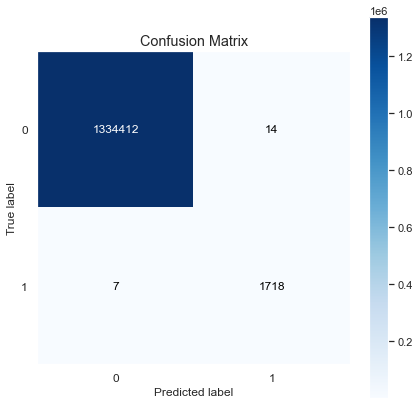

In [153]:
mt.plot_confusion_matrix(y_test, yhat_lgbm_tunned, normalize = False,figsize=(7,7))

## 9.2 Final Model (Light GBM) 

In [155]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

lgbm_tunned_result_cv = cross_validate( lgbm_tunned,x_train.values, y_train.values,scoring=scoring)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

In [156]:
results_cv(lgbm_tunned_result_cv)

,Accuracy CV,F1-Score CV,Recall CV,Precision_score CV
0,0.998968 +/- 0.00065775,0.998973 +/- 0.0006557,0.997956 +/- 0.00130874,0.999992 +/- 4.88e-06


In [159]:
lgbm_tunned_result

,Model,Accuracy,F1-Score,Recall,Precision_score
0,LGBM Classifier tunned,0.999984,0.993925,0.995942,0.991917


In [158]:
# save the model to disk
pickle.dump(lgbm_tunned, open('finalized_model.pkl', 'wb'))

As noted, the optimization results were not more satisfactory than the previous one, due to one of the parameters, default = None, which was not used in Random Search Cross Validation. This error must be corrected later in the next project cycle.

Therefore, the final model of the project will be the Random Forest before optimization, it has the following data:

# 10.0 Conclusion

## 10.1 Model in production

In [39]:
class Fraud_Class( object ):
    def __init__( self ):
        #self.home_path='/content/drive/MyDrive/PROJETOS_DS/formacao_cd/'
        self.scaler_amount                 = pickle.load( open(  'parameter/scaler_amount.pkl', 'rb') )
        self.scaler_oldbalance_org         = pickle.load( open(  'parameter/scaler_oldbalance_org.pkl', 'rb') )
        self.scaler_newbalance_orig        = pickle.load( open(  'parameter/scaler_newbalance_orig.pkl', 'rb') )
        self.scaler_oldbalance_dest        = pickle.load( open(  'parameter/scaler_oldbalance_dest.pkl', 'rb') )   
        self.scaler_newbalance_dest        = pickle.load( open(  'parameter/scaler_newbalance_dest.pkl', 'rb') )  
        self.scaler_error_balance_orig     = pickle.load( open(  'parameter/scaler_error_balance_orig.pkl', 'rb') )
        self.scaler_error_balance_dest     = pickle.load( open(  'parameter/scaler_error_balance_dest.pkl', 'rb') )
        self.scaler_step                   = pickle.load( open(  'parameter/scaler_step.pkl', 'rb') )
        self.scaler_day                    = pickle.load( open(  'parameter/scaler_day.pkl', 'rb') )
        #self.scaler_day                   = pickle.load( open( self.home_path + 'parameter/scaler_day.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud']

        cols_new = ['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud']

        # rename
        df1.columns = cols_new

        # MUDANÇA DE dtype        
        df1[['is_fraud','is_flagged_fraud']] = df1[['is_fraud','is_flagged_fraud']].astype(object)
        
        return df1 


    ##############################################################################################
    def data_preparation( self, df2 ):
        
        ## hour
        df2['hour'] = df2['step'].apply(lambda x: x%24)

        df2['outside_normal_hour'] = df2['step'].apply(lambda x: 1 if (0<x<7) else 0 )

        ## day
        df2['day'] = df2['step'].apply(lambda x: int(x/24) + 1)

        ## week
        df2['week'] = df2['day'].apply(lambda x: 1 if (x<=7) else 2 if (x <=14) else 3 if (x <=21) else 4)

        # amount
        df2['aux_amount'] = df2['type'].apply(lambda x: -1 if x =="CASH_IN" else 1)
        df2['amount'] = df2['amount'] * df2['aux_amount']
        df2 = df2.drop(columns=['aux_amount'])

        df2['amount_is_zero'] = df2['amount'].apply(lambda x: 1 if x == 0 else 0)

        #name_orig
        df2['client_orig'] = df2['name_orig'].apply(lambda x: 'merchant' if "M" in x else "non-merchant")
        df2 = df2.drop(columns=['name_orig'])

        #name_dest
        df2['client_dest'] = df2['name_dest'].apply(lambda x: "merchant" if "M" in x else "non-merchant")
        df2 = df2.drop(columns=['name_dest'])

        #difference between old and new balance 
        df2['error_balance_orig'] = np.round((df2['newbalance_orig'] + df2['amount'] - df2['oldbalance_org']),3)

        aux1 = df2[df2['client_dest']=='non-merchant'] 

        df2['error_balance_dest'] = np.round((aux1['newbalance_dest'] - aux1['amount'] - aux1['oldbalance_dest']),3)
        df2.error_balance_dest.fillna(0, inplace=True)
        
        
        ##############

        df2['amount']                      = self.scaler_amount.transform( df2[['amount']].values )    
        df2['oldbalance_org']              = self.scaler_oldbalance_org.transform( df2[['oldbalance_org']].values )
        df2['newbalance_orig']             = self.scaler_newbalance_orig.transform( df2[['newbalance_orig']].values )       
        df2['oldbalance_dest']             = self.scaler_oldbalance_dest.transform( df2[['oldbalance_dest']].values )
        df2['newbalance_dest']             = self.scaler_newbalance_dest.transform( df2[['newbalance_dest']].values )
        df2['error_balance_orig']         = self.scaler_error_balance_orig.transform( df2[['error_balance_orig']].values )
        df2['error_balance_dest']          = self.scaler_error_balance_dest.transform( df2[['error_balance_dest']].values )
        df2['step']                        = self.scaler_step.transform( df2[['step']].values )
        df2['day']                         = self.scaler_day.transform( df2[['day']].values )
        
        
        ##############
        

        types                             = {"CASH_IN":0,'CASH_OUT':1,'DEBIT':2,'PAYMENT':3,'TRANSFER':4}
        clients                           = {'non-merchant':'0','merchant':1}
        df2['type']                       = df2['type'].map(types)
        df2['client_orig']                = df2['client_orig'].map(clients)
        df2['client_dest']                = df2['client_dest'].map(clients)


        df2['hour_sin']                   = df2['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
        df2['hour_cos']                   = df2['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
        df2                               = df2.drop(columns=['hour'])


        df2['is_fraud']                   = df2['is_fraud'].convert_dtypes(convert_integer=True)
        df2['is_fraud']                   = df2['is_fraud'].astype('int64')
        df2['is_flagged_fraud']           = df2['is_flagged_fraud'].convert_dtypes(convert_integer=True)
        df2['is_flagged_fraud']           = df2['is_flagged_fraud'].astype('int64')

        
        cols_selected = ['step','type','amount','oldbalance_org','newbalance_orig','oldbalance_dest',
                         'newbalance_dest','day','error_balance_orig','error_balance_dest','hour_sin',
                         'hour_cos','amount_is_zero', 'is_flagged_fraud']
        
        
        return df2[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = pred
        original_data['prediction'] = original_data['prediction'].convert_dtypes(convert_integer=True)
        
        
        return original_data

In [40]:
# carregando os dados :
df_to_predict = df_final_test.copy()

# loading model
loaded_model = pickle.load(open('finalized_model.pkl', 'rb'))

# Instantiate Rossmann class
pipeline = Fraud_Class()
        
# data cleaning
df1 = pipeline.data_cleaning( df_to_predict )
        
# data preparation
df2 = pipeline.data_preparation( df1 )
        
# prediction
df_response = pipeline.get_prediction( loaded_model, df_to_predict, df2 )

In [41]:
df_response.head(10)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,hour,outside_normal_hour,day,week,aux_amount,prediction
1453282,140,PAYMENT,6974.39,C2082621352,10503.00,3528.61,M1499555496,0.00,0.00,0,0,20,0,6,1,1,0
5338477,374,CASH_IN,-157690.96,C452124917,16627.00,174317.96,C1856284436,73436.77,0.00,0,0,14,0,16,3,-1,0
2396500,201,PAYMENT,17907.49,C1149130676,16282.06,0.00,M811584793,0.00,0.00,0,0,9,0,9,2,1,0
4577381,328,PAYMENT,22394.94,C1869542815,75530.38,53135.44,M1527681304,0.00,0.00,0,0,16,0,14,2,1,0
2922798,229,CASH_OUT,106631.35,C544369672,0.00,0.00,C285714859,2210314.37,2316945.72,0,0,13,0,10,2,1,0
5084167,355,PAYMENT,23966.74,C401846192,0.00,0.00,M1925695,0.00,0.00,0,0,19,0,15,3,1,0
5555374,383,PAYMENT,23372.98,C112713993,0.00,0.00,M1355969507,0.00,0.00,0,0,23,0,16,3,1,0
5740155,399,CASH_IN,-243887.50,C2040962204,2779222.41,3023109.91,C1204039942,259692.44,15804.94,0,0,15,0,17,3,-1,0
671083,36,PAYMENT,15856.69,C1925708891,283871.00,268014.31,M1032477154,0.00,0.00,0,0,12,0,2,1,1,0
5616348,395,CASH_IN,-306943.39,C1109840546,2631493.87,2938437.26,C1054771725,4337874.63,4030931.24,0,0,11,0,17,3,-1,0


## 10.2 Metrics

In [53]:
y_test_matrix = df_response['is_fraud'].astype(int)
y_p_matrix = df_response['prediction'].astype(int)

print(classification_report(y_test_matrix, y_p_matrix))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.99      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

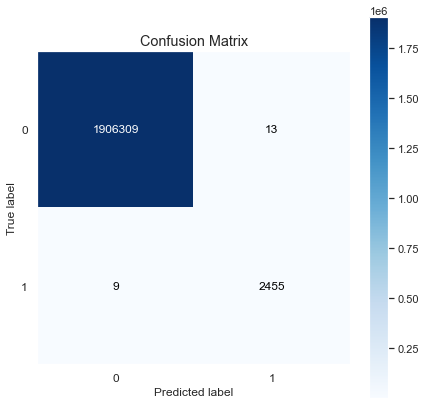

In [54]:
mt.plot_confusion_matrix(y_test_matrix, y_p_matrix, normalize = False,figsize=(7,7))



<img src="img/table2.png">

**Accuracy:** Number of correct true predictions made by the model over all kinds predictions made.

$$Accuracy = \frac{TP + TN}{TP + FP + FN + TN}$$

Accuracy should not be used as a measure in the data of the project, because the dataset is unbalanced 

&nbsp;

**F1-Score:** Average harmonic precision and recall. A model with high f1 is a model with high precision and high recall.

$$F1 Score = \frac{2 * Precision * Recall}{Precision + Recall}$$

&nbsp;

**Recall:** Proportion of real positive that was diagnosed by the algorithm as positive.

$$Recall = \frac{TP}{TP + FN}$$

gives greater emphasis to false negative errors.

&nbsp;

**Precision:** Proportion of positive that we predict that are really positive.

$$Precision = \frac{TP}{TP + FP}$$

gives greater emphasis to false positive errors.


## Problem:
    
1 - The company receives 25% of each transaction value truly detected as fraud.

2 - The company gives back 5% of each transaction value detected as fraud, however the transaction is legitimate.

3 - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is a fraud.

Questions:

- What is the model's Recall and Accuracy?

- How reliable is the model in classifying transactions as legitimate or fraudulent?

- What is the expected billing by the company if we classify 100% of transactions with the model?

## Solution:

Create a machine learning model that maximizes the number of correct classifications.

- To increase earnings, it is necessary to obtain a large amount of values truly predicted as fraud
- To reduce losses, it is necessary to obtain the minimum of (in order of relevance):
    - False negative (transaction detected as legitimate, however the transaction is a fraud)
    - False positive (transaction value detected as fraud, however the transaction is legitimate)

In other words, we want a model that maximizes recall and precision, in that order.


## 10.3 Resume

The results are:

- 99,9988% correct classifications (true positives + true negatives). &emsp;  -> Accuracy

- 99,6% of all frauds are detected. &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; -> Recall

- 99,5% of transactions classified as fraud, are really fraud. &emsp; &emsp; &emsp; &emsp;-> Precision


It was a very good result for the project. The data for production was removed at the beginning, so there was no leakage of information.

In [186]:
x_test_aux = x_test.copy()
x_test_aux['is_fraud'] = y_test
x_test_aux['predictions'] = yhat_rf

x_test_aux = x_test_aux.drop(columns=["amount"])
x_test_aux = pd.concat([x_test_aux, df4['amount']], axis=1, join="inner")

In [188]:
#x_test.shape[0]

In [57]:
#1 - The company receives 25% of each transaction value truly detected as fraud.
#fraudulent_transactions = x_test_aux[(x_test_aux['is_fraud'] == 1) & (x_test_aux['predictions'] == 1)]
#aux = fraudulent_transactions[['amount','is_fraud','predictions']].groupby(["is_fraud",'predictions']).sum().reset_index()
#aux['gain'] = aux['amount']*0.25

#print('Using a sample of 1908786 costumers:')
#print("\n")

#print("1 - Blocker Fraud Company will receive ${:,.2f} due to transactions truly detected as fraud".format(aux['gain'][0]))

#2 - The company gives back 5% of each transaction value detected as fraud, however the transaction is legitimate.
#aux1 = x_test_aux[(x_test_aux['is_fraud'] == 0) & (x_test_aux['predictions'] == 1)]
#aux2 = aux1[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
#aux2['loss'] = aux2['amount']*0.05

#print("\n")
#print("2 - Blocker Fraud Company will lose ${:,.2f} due to transactions detected as fraud, however the transaction is legitimate.".format(aux2['loss'][0]))

#3 - The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is a fraud.
#aux3 = x_test_aux[(x_test_aux['is_fraud'] == 1) & (x_test_aux['predictions'] == 0)]
#aux3 = aux3[['is_fraud','predictions','amount']].groupby(['is_fraud','predictions']).sum().reset_index()
#aux3['loss'] = aux3['amount']*1

#print("\n")
#print("3 - Blocker Fraud Company will lose ${:,.2f} due to transactions detected as legitimate, however the transaction is a fraud".format(aux3['loss'][0]))

# References

https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226

https://www.kdnuggets.com/2020/04/performance-evaluation-metrics-classification.html#:~:text=The%20key%20classification%20metrics%3A%20Accuracy,Receiver%20Operating%20Characteristic%20(ROC)%20curve

Balancing Training Data for Automated Annotation of Keywords: a Case Study